# Kastroulis, Angelo

# Approach

The open research question pursued in this project is whether Neural Networks have a place in the optimizer of SQL database systems. 

## Background

Databases have decisions to make when it comes to serving results for a query. They have to determine whether to use an index (such as a btree) or scan the entire table, is it worth spawning multiple workers to handle the request, and in which order should the predicate columns be scanned? These are not trivial and have a definite impact on performance. To make the decision, optimizers assign a cost to the various operations, and try to find the least costly path. As we will see, in most cases, even a highly tuned optimizer chooses incorrectly. Factors such as how much data is in the table vs how much we're going to return (selectivity) and what kind of hardware influence the decision, but are ever-changing. To address that, optimizers maintain statistics to at least have some idea of what is in the table.

The approach here is to benchmark the decision made by the optimizer on a standard data set, then through a grid search, find the optimal path. Once that is determined, a Neural Network will be trained to determine if it performs better or worse than the optimal and optimizer.

## TPC-H

The standard dataset used is the well known TPC-H benchmark. According to the TPCH website (tpc.org/tpch):

> The TPC Benchmark™H (TPC-H) is a decision support benchmark. It consists of a suite of business oriented ad-hoc queries and concurrent data modifications. The queries and the data populating the database have been chosen to have broad industry-wide relevance.

Additionally, I use variations of Query 6 (a single table read query of table "lineitem") of the standard to determine performance of Postgres (a well known, open source database).

The TPC-H benchmark includes tools that generate database load files. I generated ~60 million rows at ~60GB. 

First, download the TPCH tools found here: http://www.tpc.org/tpc_documents_current_versions/download_programs/tools-download-request.asp?bm_type=TPC-H&bm_vers=2.18.0&mode=CURRENT-ONLY which will give you a zip file.

Next, copy the TEST_PACKAGE folder (included here) and the zip file to your server.

```BASH
scp -i "cs89.pem" -r /Users/angelo/thesis/TEST_PACKAGE  ubuntu@SERVER.compute-1.amazonaws.com:/home/ubuntu/TEST_PACKAGE
scp -i "cs89.pem" /Users/angelo/Downloads/tpc-h-tool.zip  ubuntu@SERVER.compute-1.amazonaws.com:/home/ubuntu/tpc-h-tool.zip
```

The following BASH commands will create a database on Linux:

```BASH
sudo apt-get update
sudo apt install unzip
sudo apt install make
sudo apt install gcc

# to create a volume large enough to handle the data and artifacts:
sudo file -s /dev/nvme0n1
sudo mkfs -t xfs /dev/nvme0n1
sudo mkdir /data
sudo mount /dev/nvme0n1 /data
sudo mv tpc-h-tool.zip /data
cd /data
sudo unzip tpc-h-tool.zip

#This is the data generation tool
sudo chmod -R 777 /data/2.18.0_rc2/dbgen
cd 2.18.0_rc2/dbgen
cp makefile.suite Makefile
vim Makefile

#In the makefile, set these parameters:
#CC=gcc
#DATABASE=ORACLE
#MACHINE=LINUX
#WORKLOAD=TPCH

#now, make the file
make

#create the lineitem table (-T L) with 10x factor (-s 10) (6,000,000 rows is factor 1)
./dbgen -s 10 -T L
#Convert this pipe delimited file to CSV and remove pipe on last column because postgres can't read it
for i in `ls *.tbl`; do sed 's/|$//' $i > ${i/tbl/csv}; echo $i; done;

sudo mv /home/ubuntu/TEST_PACKAGE /data
cd /data
sudo mkdir /home/ubuntu/export
sudo chmod 777 /home/ubuntu/export

#install postgres
sudo apt install postgresql postgresql-contrib


sudo systemctl stop postgresql
sudo vim /etc/postgresql/10/main/postgresql.conf

# Move the data directory from the default disk to the one we created
data_directory = '/data/main/data'           

sudo mkdir /data/main
sudo chown postgres:postgres /data/main
sudo chmod -R 777 /data/main

#Tell postgres to reinitialize the new disk
sudo su - postgres
/usr/lib/postgresql/10/bin/initdb -D /data/main/data
exit

sudo systemctl start postgresql
sudo -u postgres psql

#create the database and run our create script
create database tpch;
\c tpch;
\i /data/TEST_PACKAGE/postgres-create-lineitem.sql

```

__Line item table__
```sql
BEGIN;

	CREATE TABLE LINEITEM (
		L_ORDERKEY		BIGINT NOT NULL, -- references O_ORDERKEY
		L_PARTKEY		BIGINT NOT NULL, -- references P_PARTKEY (compound fk to PARTSUPP)
		L_SUPPKEY		BIGINT NOT NULL, -- references S_SUPPKEY (compound fk to PARTSUPP)
		L_LINENUMBER	INTEGER,
		L_QUANTITY		DECIMAL,
		L_EXTENDEDPRICE	DECIMAL,
		L_DISCOUNT		DECIMAL,
		L_TAX			DECIMAL,
		L_RETURNFLAG	CHAR(1),
		L_LINESTATUS	CHAR(1),
		L_SHIPDATE		DATE,
		L_COMMITDATE	DATE,
		L_RECEIPTDATE	DATE,
		L_SHIPINSTRUCT	CHAR(25),
		L_SHIPMODE		CHAR(10),
		L_COMMENT		VARCHAR(44),
                PRIMARY KEY (L_ORDERKEY, L_LINENUMBER)  
	);

	COPY lineitem FROM '/data/2.18.0_rc2/dbgen/lineitem.csv' WITH (FORMAT csv, DELIMITER '|');

COMMIT;
```

# Systems

The tests will be run on 3 AWS EC2 instances; a general instance (m5d), a compute optimized (c5d), and a memory optimized (r5d). You will see from the results that the access path (scan vs index) shifts slightly depending on hardware. The following are the system specifications (from linux ``sudo lshw``)

## M5D.2XLARGE

```BASH
description: Computer
product: HVM domU
vendor: Xen
version: 4.2.amazon
serial: ec23f46e-2810-a53b-2845-4e7b0ccb3193
width: 64 bits
capabilities: smbios-2.7 dmi-2.7 smp vsyscall32
configuration: boot=normal uuid=6EF423EC-1028-3BA5-2845-4E7B0CCB3193
*-core
    description: Motherboard
    physical id: 0
    *-firmware
        description: BIOS
        vendor: Xen
        physical id: 0
        version: 4.2.amazon
        date: 08/24/2006
        size: 96KiB
        capabilities: pci edd
    *-cpu:0
        description: CPU
        product: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
        vendor: Intel Corp.
        physical id: 401
        bus info: cpu@0
        slot: CPU 1
        size: 2300MHz
        capacity: 2300MHz
        width: 64 bits
        capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology cpuid pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm cpuid_fault invpcid_single pti fsgsbase bmi1 avx2 smep bmi2 erms invpcid xsaveopt
    *-cpu:1
        description: CPU
        vendor: Intel
        physical id: 402
        bus info: cpu@1
        slot: CPU 2
        size: 2300MHz
        capacity: 2300MHz
    *-cpu:2
        description: CPU
        vendor: Intel
        physical id: 403
        bus info: cpu@2
        slot: CPU 3
        size: 2300MHz
        capacity: 2300MHz
    *-cpu:3
        description: CPU
        vendor: Intel
        physical id: 404
        bus info: cpu@3
        slot: CPU 4
        size: 2300MHz
        capacity: 2300MHz
    *-cpu:4
        description: CPU
        vendor: Intel
        physical id: 405
        bus info: cpu@4
        slot: CPU 5
        size: 2300MHz
        capacity: 2300MHz
    *-cpu:5
        description: CPU
        vendor: Intel
        physical id: 406
        bus info: cpu@5
        slot: CPU 6
        size: 2300MHz
        capacity: 2300MHz
    *-cpu:6
        description: CPU
        vendor: Intel
        physical id: 407
        bus info: cpu@6
        slot: CPU 7
        size: 2300MHz
        capacity: 2300MHz
    *-cpu:7
        description: CPU
        vendor: Intel
        physical id: 408
        bus info: cpu@7
        slot: CPU 8
        size: 2300MHz
        capacity: 2300MHz
    *-memory
        description: System Memory
        physical id: 1000
        size: 32GiB
        capabilities: ecc
        configuration: errordetection=multi-bit-ecc
        *-bank:0
            description: DIMM RAM
            physical id: 0
            slot: DIMM 0
            size: 16GiB
            width: 64 bits
        *-bank:1
            description: DIMM RAM
            physical id: 1
            slot: DIMM 1
            size: 16GiB
            width: 64 bits
    *-pci
        description: Host bridge
        product: 440FX - 82441FX PMC [Natoma]
        vendor: Intel Corporation
        physical id: 100
        bus info: pci@0000:00:00.0
        version: 02
        width: 32 bits
        clock: 33MHz
        *-isa
            description: ISA bridge
            product: 82371SB PIIX3 ISA [Natoma/Triton II]
            vendor: Intel Corporation
            physical id: 1
            bus info: pci@0000:00:01.0
            version: 00
            width: 32 bits
            clock: 33MHz
            capabilities: isa bus_master
            configuration: latency=0
        *-ide
            description: IDE interface
            product: 82371SB PIIX3 IDE [Natoma/Triton II]
            vendor: Intel Corporation
            physical id: 1.1
            bus info: pci@0000:00:01.1
            version: 00
            width: 32 bits
            clock: 33MHz
            capabilities: ide bus_master
            configuration: driver=ata_piix latency=64
            resources: irq:0 ioport:1f0(size=8) ioport:3f6 ioport:170(size=8) ioport:376 ioport:c100(size=16)
        *-bridge UNCLAIMED
            description: Bridge
            product: 82371AB/EB/MB PIIX4 ACPI
            vendor: Intel Corporation
            physical id: 1.3
            bus info: pci@0000:00:01.3
            version: 01
            width: 32 bits
            clock: 33MHz
            capabilities: bridge bus_master
            configuration: latency=0
        *-display UNCLAIMED
            description: VGA compatible controller
            product: GD 5446
            vendor: Cirrus Logic
            physical id: 2
            bus info: pci@0000:00:02.0
            version: 00
            width: 32 bits
            clock: 33MHz
            capabilities: vga_controller bus_master
            configuration: latency=0
            resources: memory:f0000000-f1ffffff memory:f3008000-f3008fff memory:c0000-dffff
        *-network
            description: Ethernet interface
            product: 82599 Ethernet Controller Virtual Function
            vendor: Intel Corporation
            physical id: 3
            bus info: pci@0000:00:03.0
            logical name: ens3
            version: 01
            serial: 02:f1:7c:7e:86:04
            size: 10Gbit/s
            capacity: 10Gbit/s
            width: 64 bits
            clock: 33MHz
            capabilities: msix bus_master cap_list ethernet physical 10000bt-fd
            configuration: autonegotiation=off broadcast=yes driver=ixgbevf driverversion=4.1.0-k duplex=full ip=172.31.73.117 latency=64 link=yes multicast=yes speed=10Gbit/s
            resources: irq:0 memory:f3000000-f3003fff memory:f3004000-f3007fff
        *-generic
            description: Unassigned class
            product: Xen Platform Device
            vendor: XenSource, Inc.
            physical id: 1f
            bus info: pci@0000:00:1f.0
            version: 01
            width: 32 bits
            clock: 33MHz
            capabilities: bus_master
            configuration: driver=xen-platform-pci latency=0
            resources: irq:47 ioport:c000(size=256) memory:f2000000-f2ffffff


                      system     HVM domU
/0                  bus        Motherboard
/0/0                memory     96KiB BIOS
/0/401              processor  Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
/0/402              processor  CPU
/0/403              processor  CPU
/0/404              processor  CPU
/0/405              processor  CPU
/0/406              processor  CPU
/0/407              processor  CPU
/0/408              processor  CPU
/0/1000             memory     32GiB System Memory
/0/1000/0           memory     16GiB DIMM RAM
/0/1000/1           memory     16GiB DIMM RAM
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.1          storage    82371SB PIIX3 IDE [Natoma/Triton II]
/0/100/1.3          bridge     82371AB/EB/MB PIIX4 ACPI
/0/100/2            display    GD 5446
/0/100/3    ens3    network    82599 Ethernet Controller Virtual Function
/0/100/1f           generic    Xen Platform Device

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              8
On-line CPU(s) list: 0-7
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
Stepping:            1
CPU MHz:             2300.107
BogoMIPS:            4600.08
Hypervisor vendor:   Xen
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0-7
```

## C5D.4XLARGE
```BASH
description: Computer
product: c5d.4xlarge
vendor: Amazon EC2
serial: ec222866-ec86-99c1-7d4f-c580a3d318a9
width: 64 bits
capabilities: smbios-2.7 dmi-2.7 smp vsyscall32
configuration: uuid=662822EC-86EC-C199-7D4F-C580A3D318A9
  *-core
       description: Motherboard
       vendor: Amazon EC2
       physical id: 0
     *-firmware
          description: BIOS
          vendor: Amazon EC2
          physical id: 0
          version: 1.0
          date: 10/16/2017
          size: 64KiB
          capabilities: pci edd acpi virtualmachine
     *-cpu
          description: CPU
          product: Intel(R) Xeon(R) Platinum 8124M CPU @ 3.00GHz
          vendor: Intel Corp.
          physical id: 4
          bus info: cpu@0
          version: Intel(R) Xeon(R) Platinum 8124M CPU @ 3.00GHz
          slot: CPU 0
          size: 3GHz
          capacity: 3500MHz
          width: 64 bits
          clock: 100MHz
          capabilities: x86-64 fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp constant_tsc rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves ida arat pku ospke
          configuration: cores=8 enabledcores=8 threads=16
     *-memory
          description: System memory
          physical id: 1
          size: 30GiB
     *-pci
          description: Host bridge
          product: 440FX - 82441FX PMC [Natoma]
          vendor: Intel Corporation
          physical id: 100
          bus info: pci@0000:00:00.0
          version: 00
          width: 32 bits
          clock: 33MHz
        *-isa
             description: ISA bridge
             product: 82371SB PIIX3 ISA [Natoma/Triton II]
             vendor: Intel Corporation
             physical id: 1
             bus info: pci@0000:00:01.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: isa
             configuration: latency=0
        *-generic UNCLAIMED
             description: Non-VGA unclassified device
             product: 82371AB/EB/MB PIIX4 ACPI
             vendor: Intel Corporation
             physical id: 1.3
             bus info: pci@0000:00:01.3
             version: 08
             width: 32 bits
             clock: 33MHz
             configuration: latency=0
        *-display UNCLAIMED
             description: VGA compatible controller
             physical id: 3
             bus info: pci@0000:00:03.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: vga_controller
             configuration: latency=0
             resources: memory:fe400000-fe7fffff memory:c0000-dffff
        *-storage:0
             description: Non-Volatile memory controller
             physical id: 4
             bus info: pci@0000:00:04.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: storage pciexpress msix nvm_express bus_master cap_list
             configuration: driver=nvme latency=0
             resources: irq:11 memory:febf0000-febf3fff
        *-network
             description: Ethernet interface
             physical id: 5
             bus info: pci@0000:00:05.0
             logical name: ens5
             version: 00
             serial: 02:fb:36:51:5c:5e
             width: 32 bits
             clock: 33MHz
             capabilities: pciexpress msix bus_master cap_list ethernet physical
             configuration: broadcast=yes driver=ena driverversion=2.0.2K ip=172.31.76.62 latency=0 link=yes multicast=yes
             resources: irq:0 memory:febf4000-febf7fff memory:fe800000-fe8fffff memory:febe0000-febeffff
        *-storage:1
             description: Non-Volatile memory controller
             physical id: 1f
             bus info: pci@0000:00:1f.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: storage pciexpress msix nvm_express bus_master cap_list
             configuration: driver=nvme latency=0
             resources: irq:0 memory:febf8000-febfbfff memory:fe900000-fe901fff
ubuntu@ip-172-31-76-62:~$ sudo lshw -short
H/W path    Device  Class      Description
==========================================
                    system     c5d.4xlarge
/0                  bus        Motherboard
/0/0                memory     64KiB BIOS
/0/4                processor  Intel(R) Xeon(R) Platinum 8124M CPU @ 3.00GHz
/0/1                memory     30GiB System memory
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.3          generic    82371AB/EB/MB PIIX4 ACPI
/0/100/3            display    VGA compatible controller
/0/100/4            storage    Non-Volatile memory controller
/0/100/5    ens5    network    Ethernet interface
/0/100/1f           storage    Non-Volatile memory controller
ubuntu@ip-172-31-76-62:~$ lscpu
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              16
On-line CPU(s) list: 0-15
Thread(s) per core:  2
Core(s) per socket:  8
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) Platinum 8124M CPU @ 3.00GHz
Stepping:            4
CPU MHz:             3405.776
BogoMIPS:            6000.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            25344K
NUMA node0 CPU(s):   0-15
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves ida arat pku ospke
ubuntu@ip-172-31-76-62:~$ lsblk
NAME        MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
loop0         7:0    0    91M  1 loop /snap/core/6350
loop1         7:1    0    18M  1 loop /snap/amazon-ssm-agent/930
nvme0n1     259:0    0 372.5G  0 disk 
nvme1n1     259:1    0     8G  0 disk 
└─nvme1n1p1 259:2    0     8G  0 part /
```

## R5D.4XLARGE

```BASH
    description: Computer
    product: r5d.4xlarge
    vendor: Amazon EC2
    serial: ec25457f-0859-edab-7cf7-1777af63059a
    width: 64 bits
    capabilities: smbios-2.7 dmi-2.7 smp vsyscall32
    configuration: uuid=7F4525EC-5908-ABED-7CF7-1777AF63059A
  *-core
       description: Motherboard
       vendor: Amazon EC2
       physical id: 0
     *-firmware
          description: BIOS
          vendor: Amazon EC2
          physical id: 0
          version: 1.0
          date: 10/16/2017
          size: 64KiB
          capabilities: pci edd acpi virtualmachine
     *-cpu
          description: CPU
          product: Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
          vendor: Intel Corp.
          physical id: 4
          bus info: cpu@0
          version: Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
          slot: CPU 0
          size: 2500MHz
          capacity: 3500MHz
          width: 64 bits
          clock: 100MHz
          capabilities: x86-64 fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp constant_tsc rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves ida arat pku ospke
          configuration: cores=8 enabledcores=8 threads=16
     *-memory
          description: System memory
          physical id: 1
          size: 124GiB
     *-pci
          description: Host bridge
          product: 440FX - 82441FX PMC [Natoma]
          vendor: Intel Corporation
          physical id: 100
          bus info: pci@0000:00:00.0
          version: 00
          width: 32 bits
          clock: 33MHz
        *-isa
             description: ISA bridge
             product: 82371SB PIIX3 ISA [Natoma/Triton II]
             vendor: Intel Corporation
             physical id: 1
             bus info: pci@0000:00:01.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: isa
             configuration: latency=0
        *-generic UNCLAIMED
             description: Non-VGA unclassified device
             product: 82371AB/EB/MB PIIX4 ACPI
             vendor: Intel Corporation
             physical id: 1.3
             bus info: pci@0000:00:01.3
             version: 08
             width: 32 bits
             clock: 33MHz
             configuration: latency=0
        *-display UNCLAIMED
             description: VGA compatible controller
             physical id: 3
             bus info: pci@0000:00:03.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: vga_controller
             configuration: latency=0
             resources: memory:fe400000-fe7fffff memory:c0000-dffff
        *-storage:0
             description: Non-Volatile memory controller
             physical id: 4
             bus info: pci@0000:00:04.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: storage pciexpress msix nvm_express bus_master cap_list
             configuration: driver=nvme latency=0
             resources: irq:11 memory:febf0000-febf3fff
        *-network
             description: Ethernet interface
             physical id: 5
             bus info: pci@0000:00:05.0
             logical name: ens5
             version: 00
             serial: 02:4d:8b:7d:1b:28
             width: 32 bits
             clock: 33MHz
             capabilities: pciexpress msix bus_master cap_list ethernet physical
             configuration: broadcast=yes driver=ena driverversion=2.0.2K ip=172.31.75.157 latency=0 link=yes multicast=yes
             resources: irq:0 memory:febf4000-febf7fff memory:fe800000-fe8fffff memory:febe0000-febeffff
        *-storage:1
             description: Non-Volatile memory controller
             physical id: 1e
             bus info: pci@0000:00:1e.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: storage pciexpress msix nvm_express bus_master cap_list
             configuration: driver=nvme latency=0
             resources: irq:0 memory:febf8000-febfbfff memory:fe900000-fe901fff
        *-storage:2
             description: Non-Volatile memory controller
             physical id: 1f
             bus info: pci@0000:00:1f.0
             version: 00
             width: 32 bits
             clock: 33MHz
             capabilities: storage pciexpress msix nvm_express bus_master cap_list
             configuration: driver=nvme latency=0
             resources: irq:0 memory:febfc000-febfffff memory:fe902000-fe903fff
ubuntu@ip-172-31-75-157:~$ sudo lshw -short
H/W path    Device  Class      Description
==========================================
                    system     r5d.4xlarge
/0                  bus        Motherboard
/0/0                memory     64KiB BIOS
/0/4                processor  Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
/0/1                memory     124GiB System memory
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.3          generic    82371AB/EB/MB PIIX4 ACPI
/0/100/3            display    VGA compatible controller
/0/100/4            storage    Non-Volatile memory controller
/0/100/5    ens5    network    Ethernet interface
/0/100/1e           storage    Non-Volatile memory controller
/0/100/1f           storage    Non-Volatile memory controller
ubuntu@ip-172-31-75-157:~$ lscpu
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              16
On-line CPU(s) list: 0-15
Thread(s) per core:  2
Core(s) per socket:  8
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) Platinum 8175M CPU @ 2.50GHz
Stepping:            4
CPU MHz:             3110.950
BogoMIPS:            5000.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            33792K
NUMA node0 CPU(s):   0-15
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves ida arat pku ospke
ubuntu@ip-172-31-75-157:~$ lsblk
NAME        MAJ:MIN RM   SIZE RO TYPE MOUNTPOINT
loop0         7:0    0    91M  1 loop /snap/core/6350
loop1         7:1    0    18M  1 loop /snap/amazon-ssm-agent/930
nvme0n1     259:0    0 279.4G  0 disk 
nvme1n1     259:1    0 279.4G  0 disk 
nvme2n1     259:2    0     8G  0 disk 
└─nvme2n1p1 259:3    0     8G  0 part /
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#load the optimizer lines
df_c5_opt = pd.read_csv('tests/final/c5_control.txt')
df_r5_opt = pd.read_csv('tests/final/r5_control.txt')
df_m5_opt = pd.read_csv('tests/final/m5_control.txt')

In [3]:
df_c5_t3 = pd.read_csv('tests/final/c5d4xlarge-test3.txt')
df_r5_t3 = pd.read_csv('tests/final/r5d4xlarge-test3.txt')
df_m5_t3 = pd.read_csv('tests/final/m5d2xlarge-test3.txt')

# Tests
The experiments were organized in 5 tests, all variations of Query 6.

## Test 1

**Test 1** is a systematic test of one query on scan and index variations.

### Query 1
```SQL
--59986052 is the number of rows, so this gives us a the actual selectivity of the query
select cast (count(l_extendedprice) as float)/59986052 as selectivity from lineitem where l_partkey < 4000; 
...
--and step l_partkey by 4000 to 72000 giving us small increments of selectivity
select cast (count(l_extendedprice) as float)/59986052 as selectivity from lineitem where l_partkey < 72000;
```
The test is then re-run on tuning the following Postgres values:
- parallel_setup_cost (the cost of starting workers, set from 1000 to encourage workers and 1,000,000 effectively turning it off)
- enable_seqscan (allow the system to scan the table)
- enable_indexscan (allow the system to scan using the btree index)
- enable_bitmapscan (allow the system to use a bitmap scan)

## Test 2

**Test 2** expands the test by varying other parameters that tune the optimizer. This test is important to get the best possible output the optimizer can produce, making it a fair test.
- seq_page_cost (the cost of reading a sequential page)
- random_page_cost (the cost of jumping to read another page)
- cpu_tuple_cost (the cost of reconstructing a tuple)
- cpu_index_tuple_cost (the cost of recomstructing a tuple from an index)
- cpu_operator_cost (the cpu cost of performing an operation)
- parallel_setup_cost (the cost of parallelizing)
- parallel_tuple_cost (the cost of creating tuples in parallel)
- min_parallel_table_scan_size (the cost of scanning a table in parallel)
- min_parallel_index_scan_size (the cost of scanning an index in parallel)
- effective_cache_size (the amount of memory to use for cache)

Query 1 was rerun varying these parameters.

## Test 3


**Test 3** consists of 15 additional queries that use a variety of keys and columns. It forces the system to use the indexes, scan, etc., similar to Test 1, but with more variety of queries. It allows the optimizer to choose its favorite option.

### Query 2
This query tests large results. Scan will always be fastest here.
```SQL
--Run this with l_quantity from 2-4
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_quantity < 2;
```

### Query 3
This test varies l_suppkey from 200-4000 in steps of 200
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_suppkey < 200;
```

### Query 4
This test varies l_discount from .01 to .15 in steps of .01 while keeping l_quantitiy fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_discount < 0.01 and l_quantity < 2 ;
```

### Query 5
This test varies l_quantitiy from 2 to 14 in steps of 1 while keeping l_discount fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_discount < 0.01 and l_quantity < 2 ;
```

### Query 6
This test varies l_extendedprice from 100000 to 90000 in steps of 1000
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 100000 ;
```

### Query 7
This test varies l_partkey from 100000 to 2000000 in steps of 100000 while keeping l_extendedprice fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 80000 and l_partkey < 100000;
```

### Query 8
This test varies l_suppkey from 5000 to 75000 in steps of 5000 while keeping l_extendedprice fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 80000 and l_suppkey < 5000;
```

### Query 9
This test varies l_extendedprice from 75000 to 120000 in steps of 5000 while keeping l_partkey fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 75000 and l_partkey < 100000;
```

### Query 10
This test varies l_extendedprice from 75000 to 95000 in steps of 2000-3000 while keeping l_suppkey fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 75000 and l_suppkey < 50000;
```

### Query 11
This test varies l_suppkey from 75000 to 6000 in steps of 3000 while keeping l_partkey and l_extendedprice fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 75000 and l_suppkey < 75000 and l_partkey < 1200000;
```

### Query 12
This test varies l_partkey from 100000 to 1100000 in steps of 100000 while keeping l_partkey and l_extendedprice fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 75000 and l_suppkey < 75000 and l_partkey < 100000;
```

### Query 13
This test varies l_extendedprice from 75000 to 95000 in steps of 3000 while keeping l_partkey and l_suppkey fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 75000 and l_suppkey < 75000 and l_partkey < 1200000;
```

### Query 14
This test varies l_extendedprice from 80000 to 95000 in steps of 1000 and l_partkey from 1100000 to 2000000 in steps of 60000 while keeping l_suppkey fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity from lineitem where l_extendedprice > 80000 and l_suppkey < 75000 and l_partkey < 1100000;
```

### Query 15
This test varies l_extendedprice from 80000 to 95000 in steps of 1000 and l_suppkey from 55000 to 75000 in steps of 1000 while keeping l_partkey fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity  from lineitem where l_extendedprice > 80000 and l_suppkey < 55000 and l_partkey < 1200000;
```

### Query 16
This test varies l_partkey from 250000 to 900000 in steps of 50000 and l_suppkey from 25000 to 90000 in steps of 5000 while keeping l_extendedprice fixed
```SQL
select cast (count(l_extendedprice) as float)/59986052 selectivity  from lineitem where l_extendedprice > 75000 and l_suppkey < 25000 and l_partkey < 250000;
```

## Test 4

**Test 4** is Test 3, but with allowing the system to choose when to crossover for when various indexes exist or not exist. We want to see what it will do, but also (in contrast to Test 3, which is index on or off for everything), what effect does running the query with indexes on various columns make. For example, how does it perform with all conbinations of indexes on quantity, extrended price, product key, and supplier key? Does it make a difference if we have some on and some off?

Test 4 effectively removes the optimizer from the equation by running all of the queries with parallelism on/off, forcing a btree index scan (with indxes on all columns available), bitmap scan, and table scan for each. This is effectively a brute-force grid search for the most optimal path.

Let's first see what the lines for each query look like with strictly index, scan, bitmap, and compare those to the parallelized versions to see if that matters). This would let us see crossover points. That would be:

- index only Batches: 
    - 3-3 (partkey)
    - 3-5 (supp key)
    - 3-6a (discount key)
    - 3-6c (quantity key + discount key)
    - 3-8 (quantity key)
    - 3-10 (extended price key)
    - 3-11 (ep + pk)
    - 3-14 (sk + ep)
    - 3-15a (sk+pk)
    - 3-17 (sk+ep+pk)
    
- scan only: 
    - Test Batch 3-1

- bitmap:
    - 3-19 (partkey)
    - 3-21 (supp key)
    - 3-23 (discount key)
    - 3-25 (quantity key + discount key)
    - 3-27 (quantity key)
    - 3-29 (extended price key)
    - 3-31 (ep + pk)
    - 3-33 (sk + ep)
    - 3-35 (sk+pk)
    - 3-37 (sk+ep+pk)

- parallel index: 
    - 3-4 (partkey)
    - 3-6 (supp key)
    - 3-6b (discount key)
    - 3-7 (quantity key + discount key)
    - 3-9 (quantity key)
    - 3-10a (extended price key)
    - 3-12 (ep + pk)
    - 3-15 (sk + ep)
    - 3-16 (sk+pk)
    - 3-18 (sk+ep+pk)
    
- parallel scan: 
    - 3-2

- parallel bitmap:
    - 3-20 (partkey)
    - 3-22 (supp key)
    - 3-24 (discount key)
    - 3-26 (quantity key + discount key)
    - 3-28 (quantity key)
    - 3-30 (extended price key)
    - 3-32 (ep + pk)
    - 3-34 (sk + ep)
    - 3-36 (sk+pk)
    - 3-38 (sk+ep+pk)
    
## Test 5

**Test 5** performs the same test as 4, but adds and drops available indexes to give us a combination of every possible option. For example, Test 4 may run Query 16 6 times (parallel on and off for each of scan, bitmap, and btree). Test 5 will run each combination with zero indexes, index on l_partkey only, index on l_suppkey only, index on l_extendedprice only, index on l_extendedprice and l_partkey, indexes on l_partkey and l_suppkey, and indexes on l_suppkey and l_extendedprice.

In [7]:
#load the test3
def plot_query(df, optimizer, query):
    q = df[df["query"] == query]
    
    plt.figure(figsize=(16, 6))
    
    #separate the batches and plot them
    for batch_name in q["batch"].unique():
        b = q[q["batch"] == batch_name].sort_values("selectivity")
        type_name = b["type"].iloc[0]
        plt.plot(b["selectivity"], b["latency"], label= batch_name + "(" + type_name + ")" )
        
    q_o = optimizer[optimizer["query"] == query]
    plt.plot(q_o["selectivity"], q_o["latency"], label="Optimizer",linestyle='dashed')
    
    plt.title("Selectivity vs Latency for Query " + str(query))
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()
    
    # then plot the optimizer line

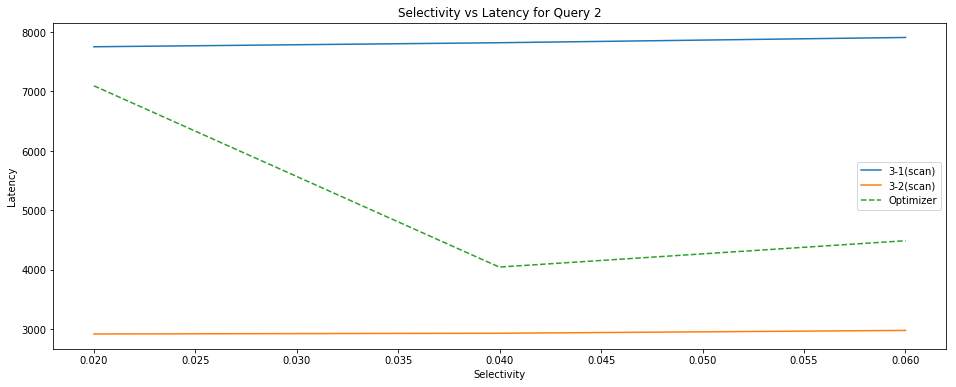

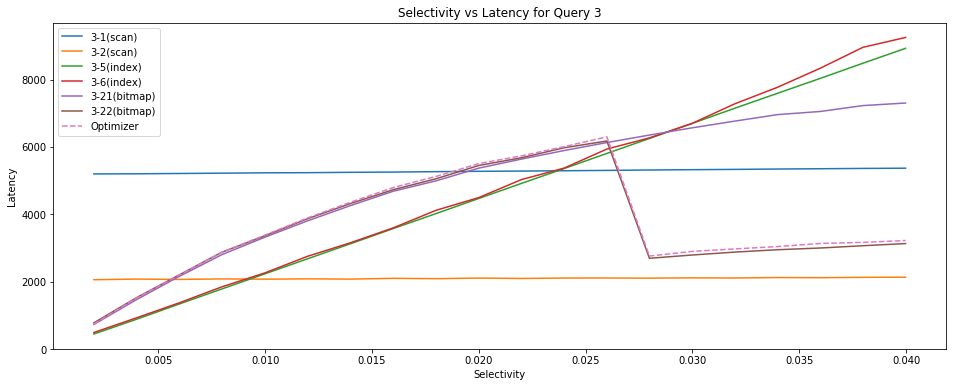

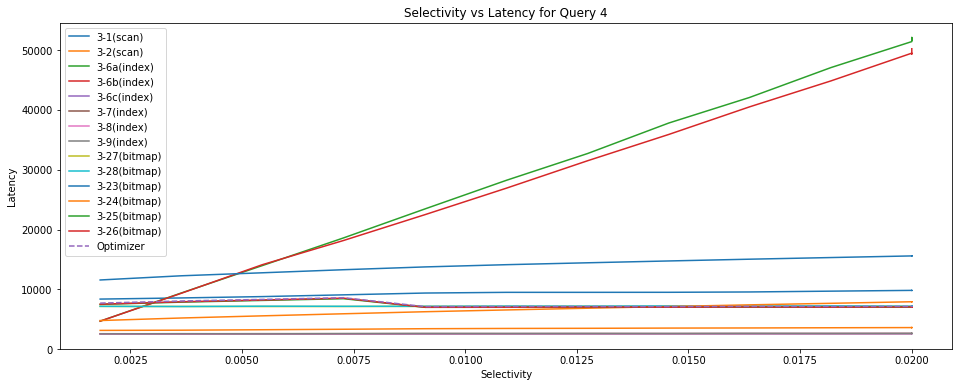

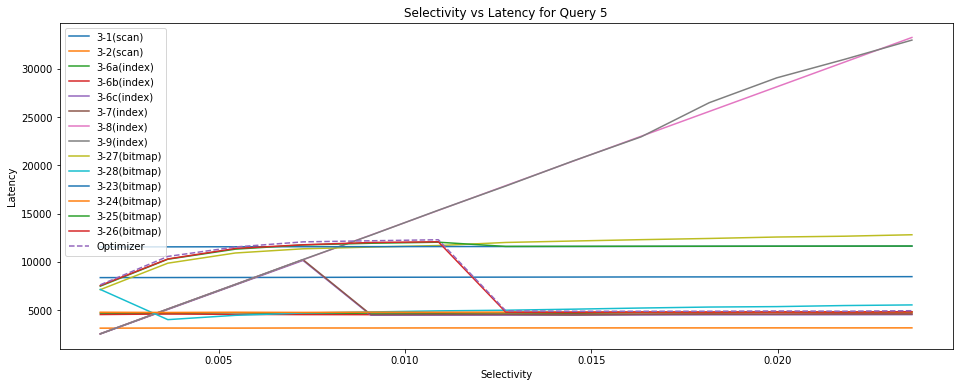

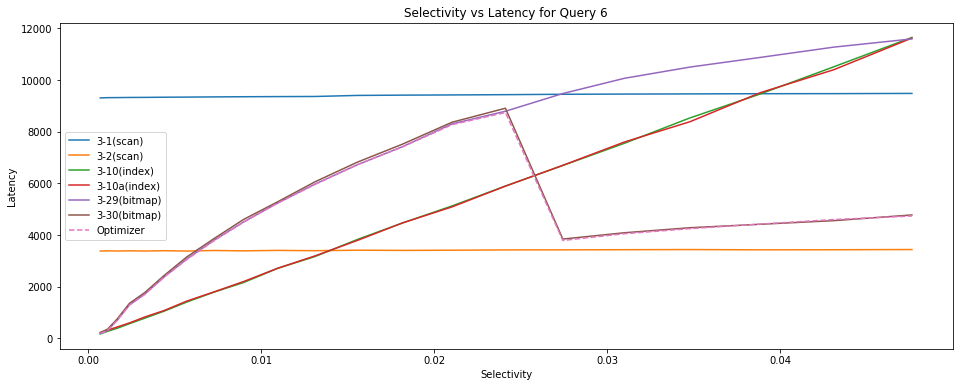

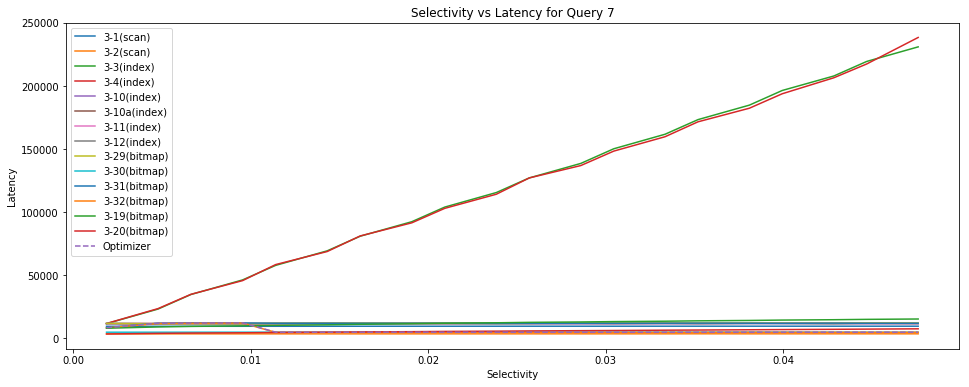

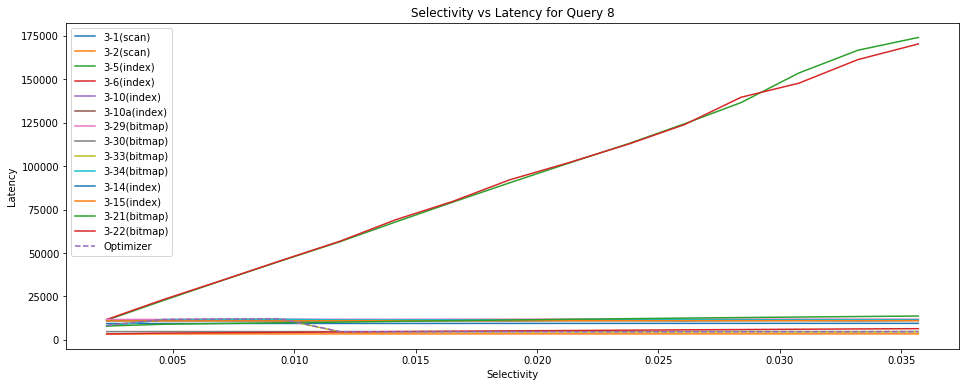

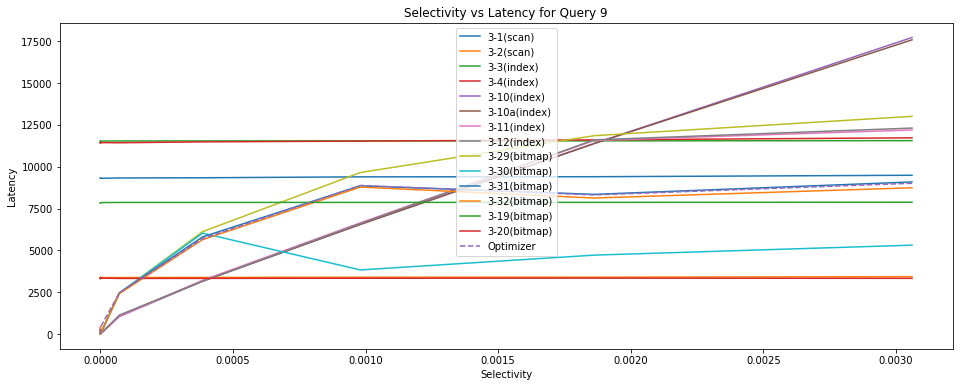

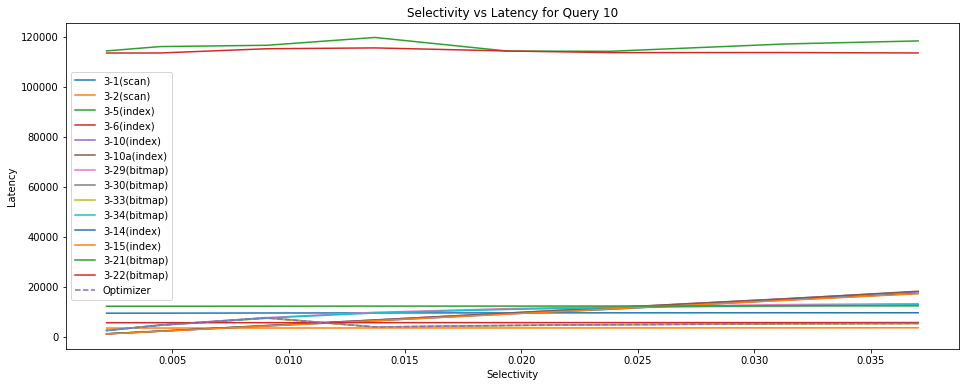

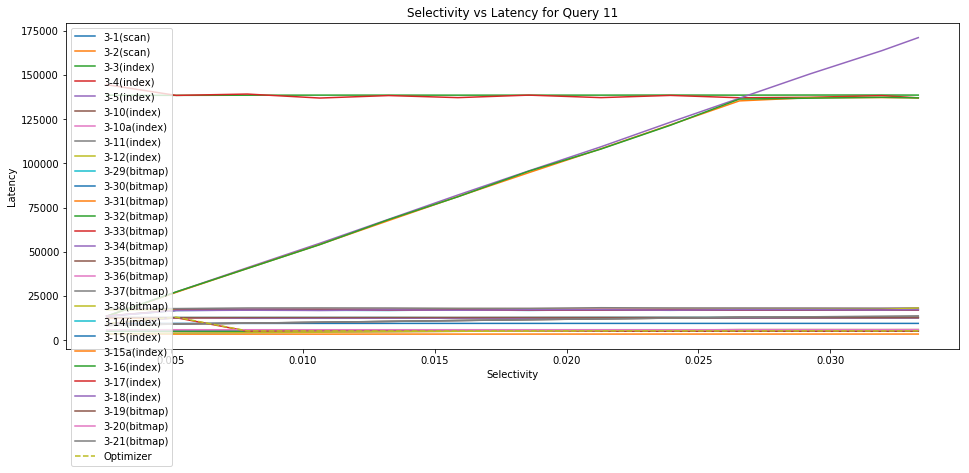

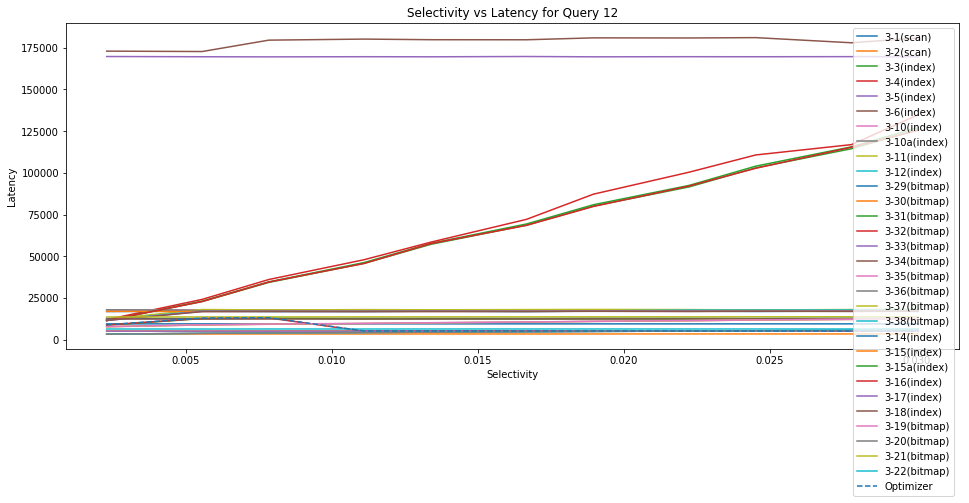

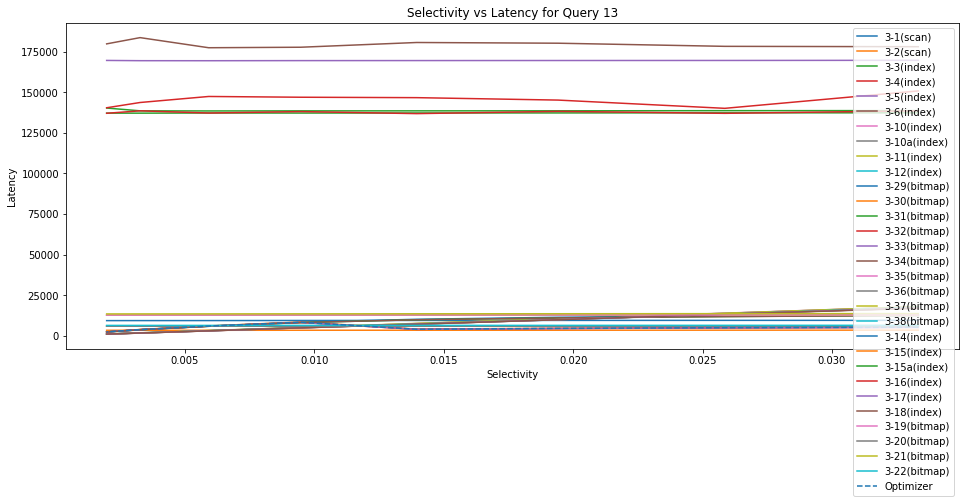

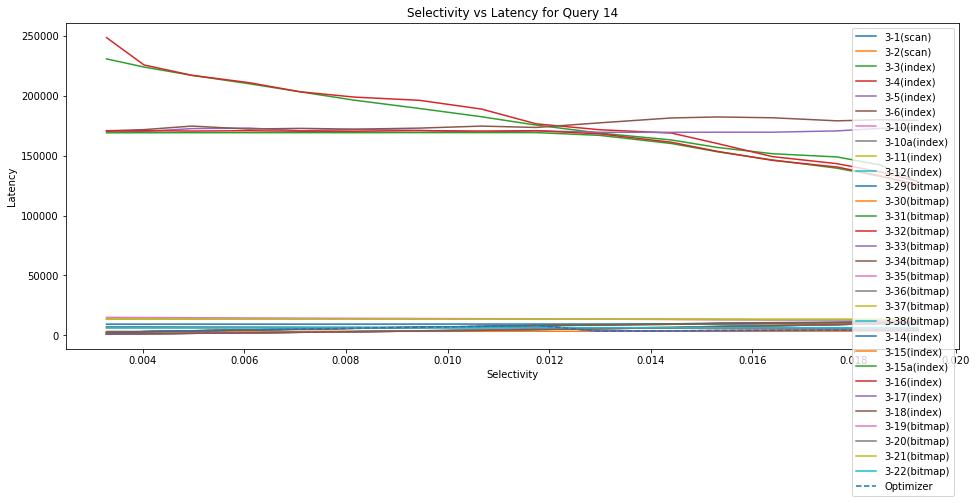

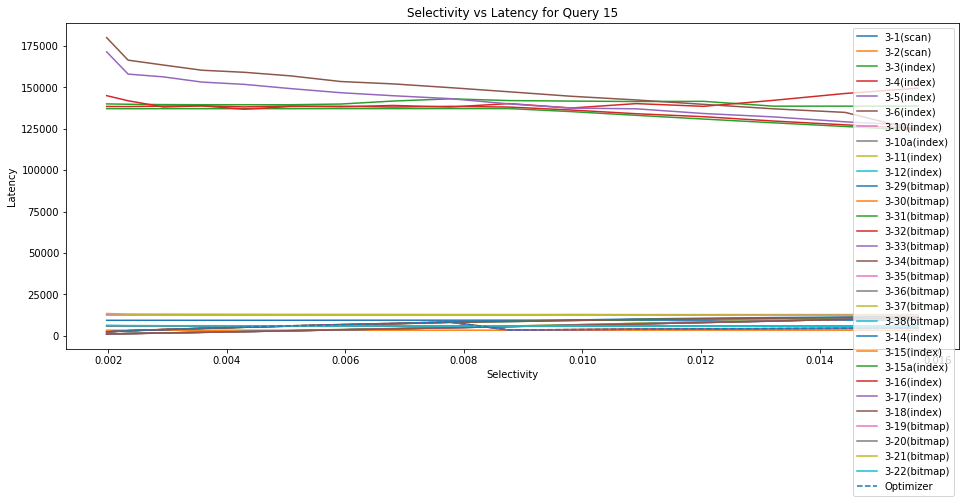

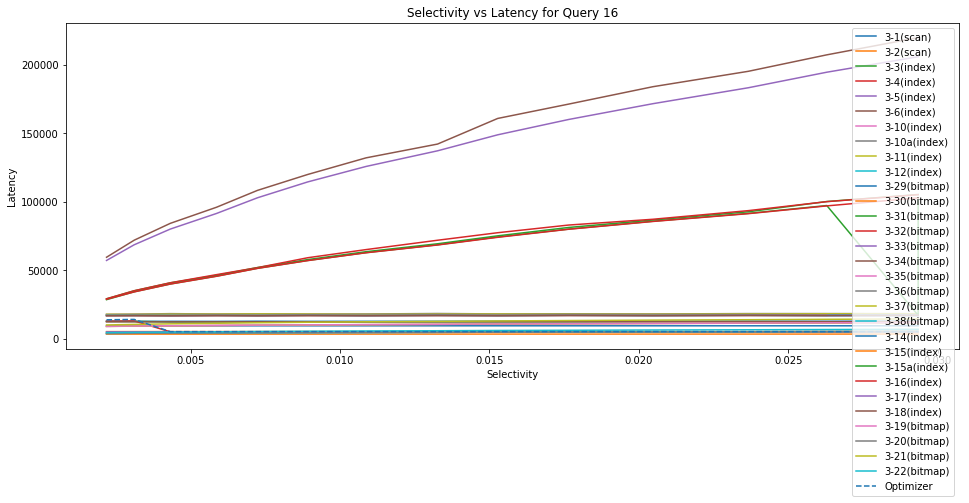

In [8]:
for q in range (2,17):
    plot_query(df_c5_t3, df_c5_opt, q)

Now, let's let look at all data and see if we can find the best line for each query... basically, find the lowest latency for each point and plot it against the optimizer.

In [9]:
#locates the combination that produces the lowest time
def find_best(df1):
    df = df1.sort_values("latency", ascending=True)
    fastest = df.groupby("selectivity", as_index=False).head(1).sort_values("selectivity")
    
    return fastest

In [10]:
def plot_tuned_vs_opt(df, opt, query):
    #q = df[df["query"] == query].sort_values("latency", ascending=True)
    
    plt.figure(figsize=(16, 6))
    
    #for each query, we want to take the fastest. So, we'll take the top for each selectivity
    fastest = find_best(df[df["query"] == query])
    #fastest = q.groupby("selectivity", as_index=False).head(1).sort_values("selectivity")
    
    plt.plot(fastest["selectivity"], fastest["latency"], label="Tuned Optimizer")
        
    q_o = opt[opt["query"] == query].sort_values("selectivity", ascending=True)
    plt.plot(q_o["selectivity"], q_o["latency"], label="Out-of-the-box Optimizer",linestyle='dashed')
    
    plt.title("Selectivity vs Latency for Query " + str(query))
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()

In [11]:
def plot_ideal_v_optimizer(df, opt, query):
    #q = df[df["query"] == query].sort_values("latency", ascending=True)
    
    plt.figure(figsize=(16, 6))
    
    #for each query, we want to take the fastest. So, we'll take the top for each selectivity
    fastest = find_best(df[df["query"] == query])
    #fastest = q.groupby("selectivity", as_index=False).head(1).sort_values("selectivity")
    
    plt.plot(fastest["selectivity"], fastest["latency"], label="True Optimal")
        
    q_o = opt[opt["query"] == query].sort_values("selectivity", ascending=True)
    plt.plot(q_o["selectivity"], q_o["latency"], label="Optimizer",linestyle='dashed')
    
    plt.title("Selectivity vs Latency for Query " + str(query))
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()

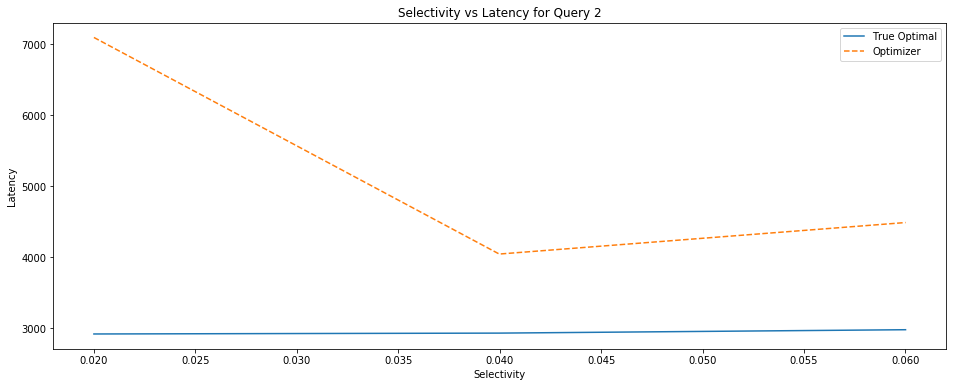

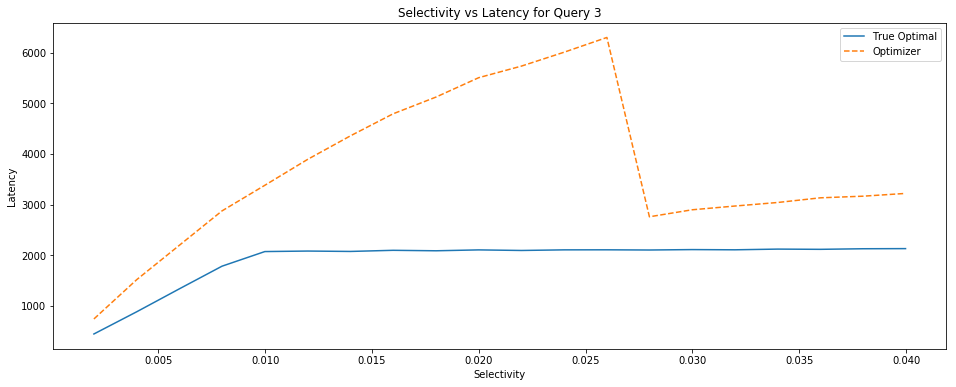

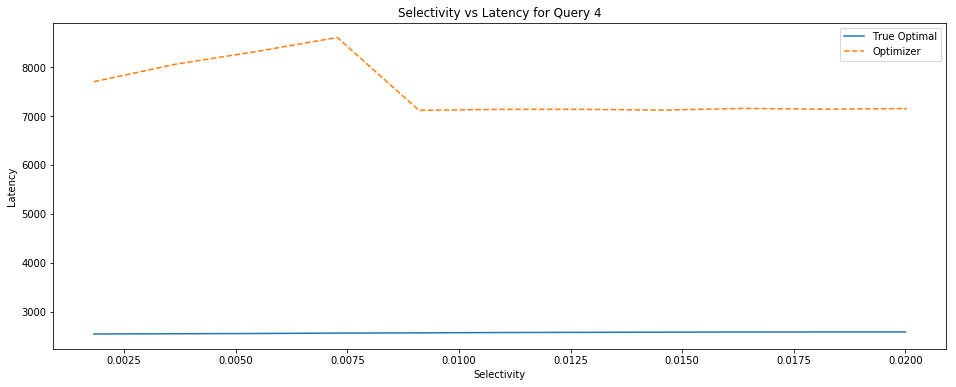

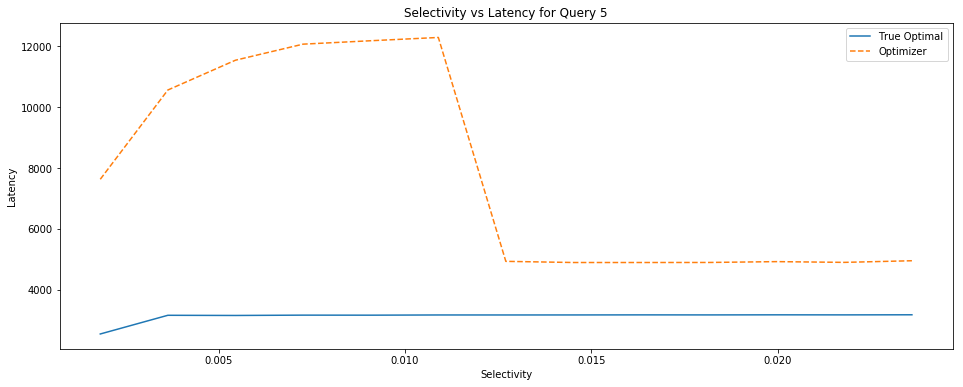

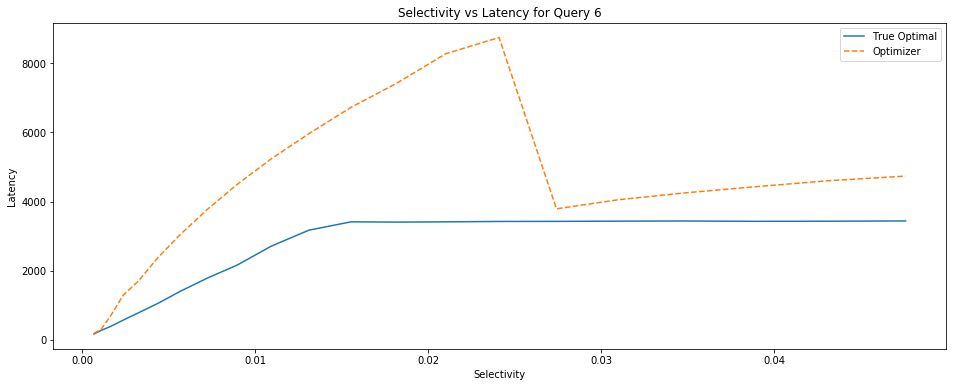

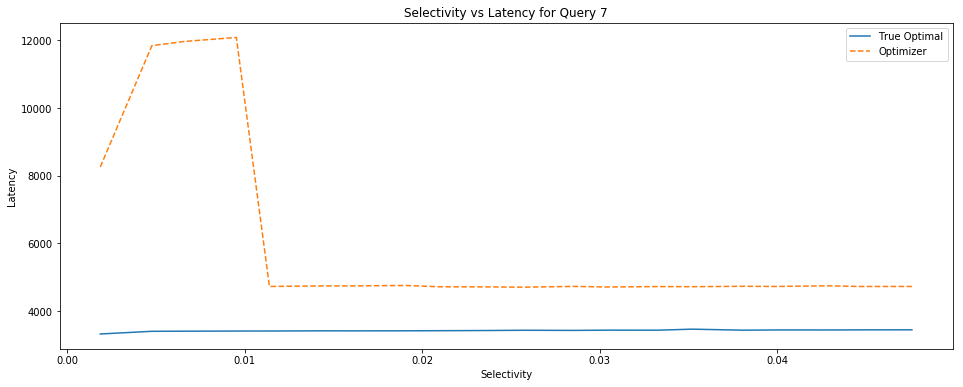

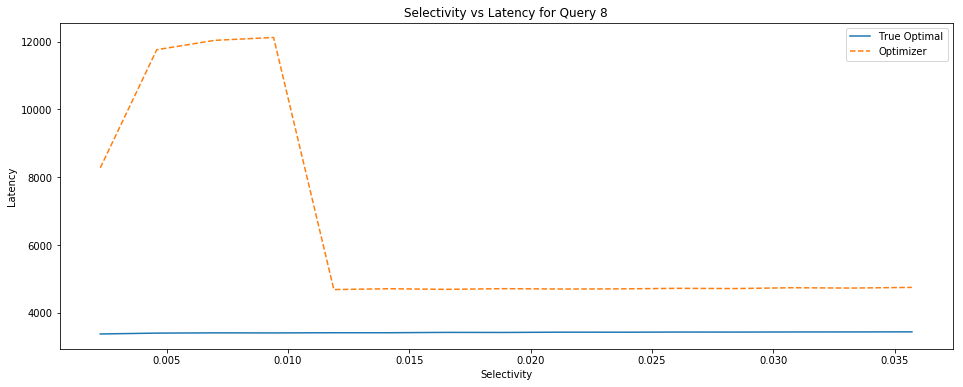

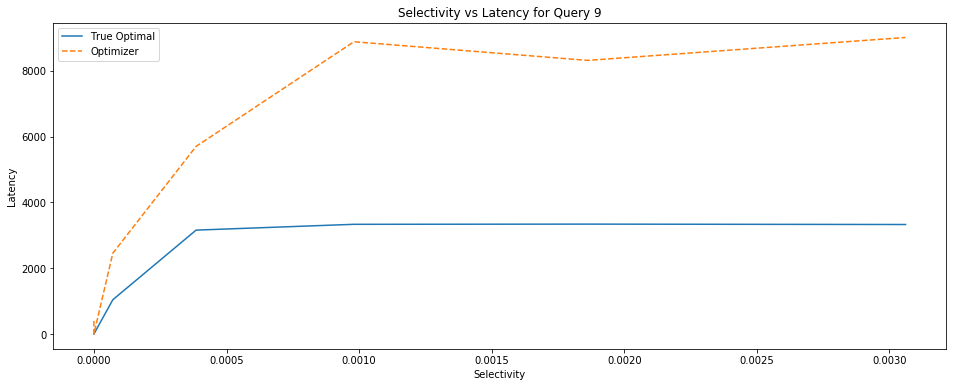

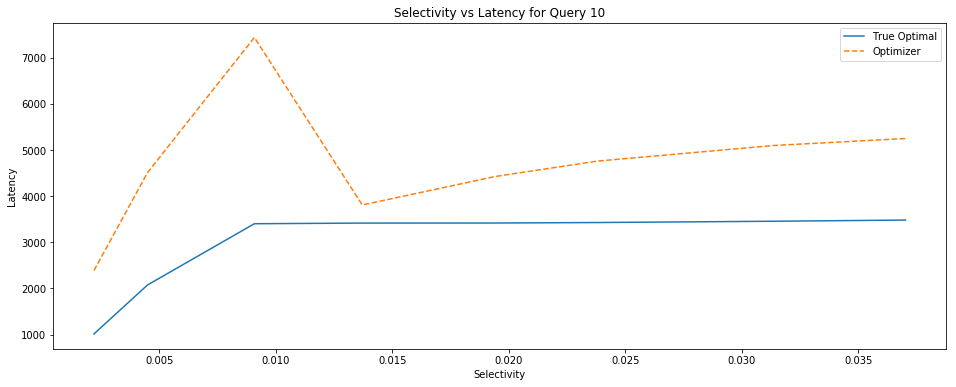

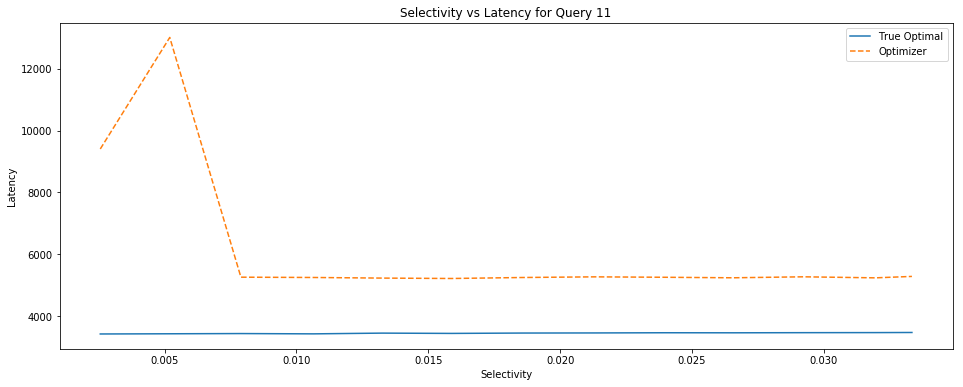

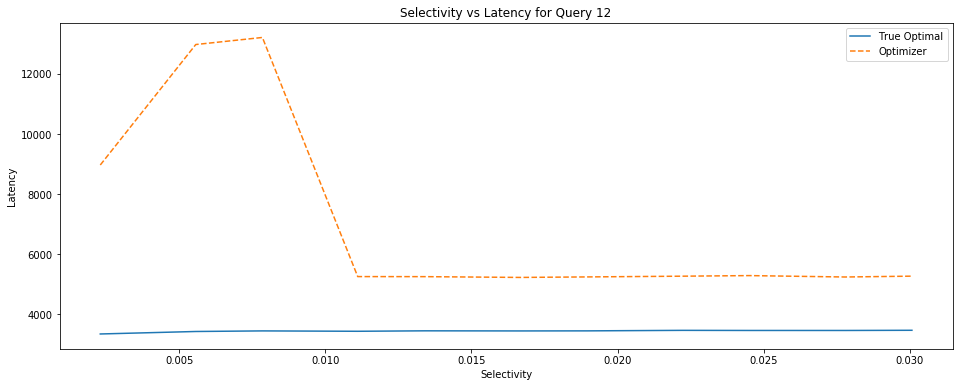

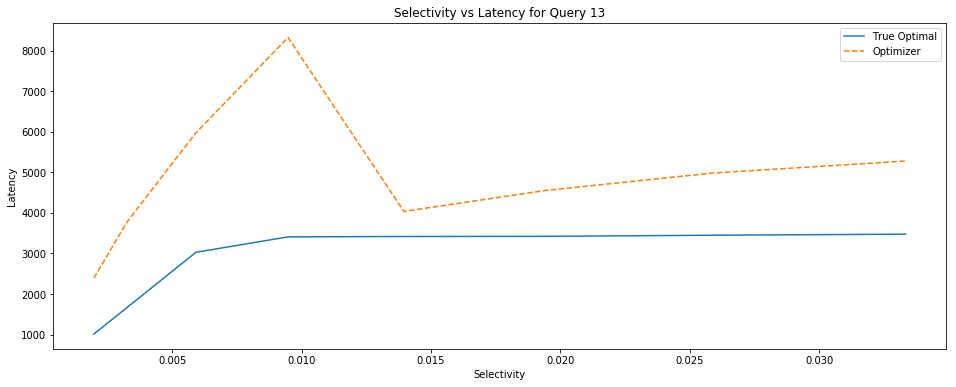

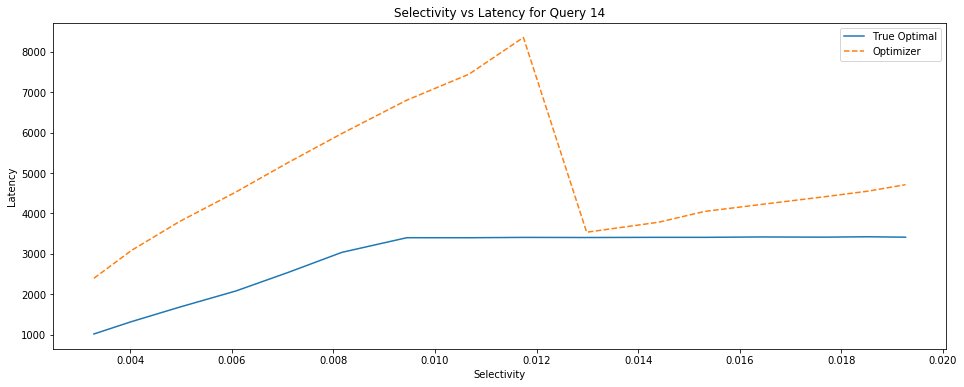

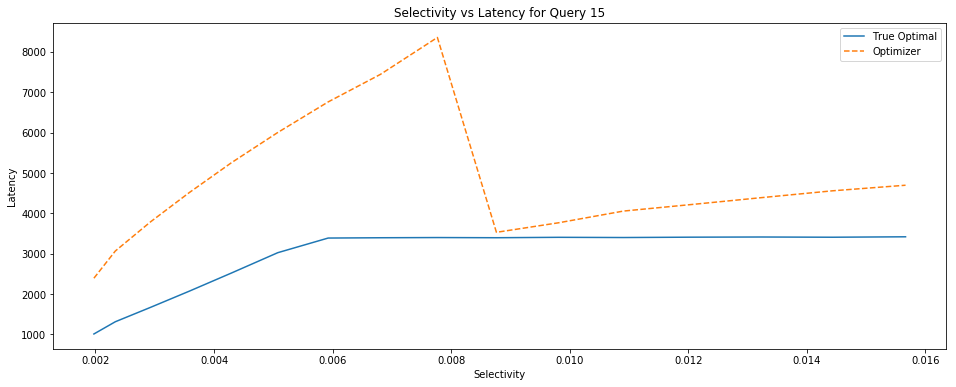

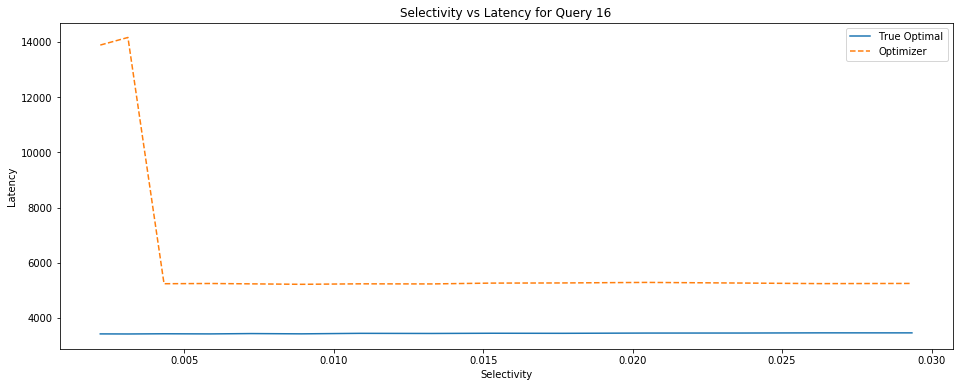

In [12]:
for q in range (2,17):
    plot_ideal_v_optimizer(df_c5_t3, df_c5_opt, q)

In [14]:
#The fastest looks like this
df = df_c5_t3
q = df[df["query"] == 2].sort_values("latency", ascending=True)
q.groupby("selectivity", as_index=False).head(1)

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
203,2,1529576.06,467391,scan,1,0,0,0,0,0,...,2,0,0,0,0.0,0,2,3-2,0.020002,2921.630
204,2,1530857.01,979772,scan,1,0,0,0,0,0,...,3,0,0,0,0.0,0,2,3-2,0.039981,2933.742
205,2,1532029.66,1448830,scan,1,0,0,0,0,0,...,4,0,0,0,0.0,0,2,3-2,0.060007,2981.543


So, an untuned optimizer makes bad decisions... what about a tuned one?

Test 2 is the test of varying the tuning parameters. Let's load that in.

In [15]:
df_c5_t2 = pd.read_csv('tests/final/c5d4xlarge-test2.txt')
df_r5_t2 = pd.read_csv('tests/final/r5d4xlarge-test2.txt')
df_m5_t2 = pd.read_csv('tests/final/m5d2xlarge-test2.txt')

In [16]:
#plain vanilla optimizer
df_t2_control = pd.read_csv('tests/final/c5d4xlarge-q1-control.txt')

In [18]:
#The tuned optimizer are batches 2-28 to 2-34
# grid search is all of the rest of test 2
df_t2_tuned = find_best(df_c5_t2[df_c5_t2["batch"].isin(['2-28','2-29','2-30','2-31','2-32','2-33','2-34'])])
df_t2_grid = find_best(df_c5_t2)

In [170]:
df_t2_tuned.head()

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,parllelmode,parallelsetupcost,seq_page_cost,random_page_cost,cpu_tuple_cost,cpu_index_tuple_cost,cpu_operator_cost,parallel_tuple_cost,min_parallel_relation_size,effective_cache_size,selectivity,latency
594,0,465155.17,115397,index,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4000,0,0,0,0,0,0,0,0,0,1,2-34,0,1000,2,4,0.01,0.005,0.0025,0.1,8.0,4,0.001997,461.787
595,0,930422.34,230823,index,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8000,0,0,0,0,0,0,0,0,0,1,2-34,0,1000,2,4,0.01,0.005,0.0025,0.1,8.0,4,0.004005,928.141
596,0,1411813.18,350249,index,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12000,0,0,0,0,0,0,0,0,0,1,2-34,0,1000,2,4,0.01,0.005,0.0025,0.1,8.0,4,0.006006,1399.252
597,0,1877080.35,465675,index,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,16000,0,0,0,0,0,0,0,0,0,1,2-34,0,1000,2,4,0.01,0.005,0.0025,0.1,8.0,4,0.008006,1866.782
598,0,2358471.18,585100,index,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,20000,0,0,0,0,0,0,0,0,0,1,2-34,0,1000,2,4,0.01,0.005,0.0025,0.1,8.0,4,0.010013,2337.746


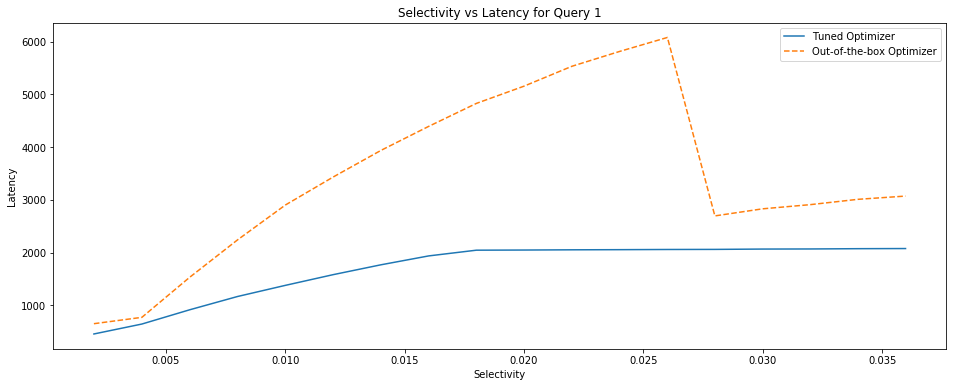

In [20]:
plot_tuned_vs_opt(df_c5_t2, df_t2_control, 1)

let's plot all 3. 
- fastest t1 (tweaking optimizer params)
- fastest t2 (not using optimizer in a brute-force grid search)
- untuned optimizer

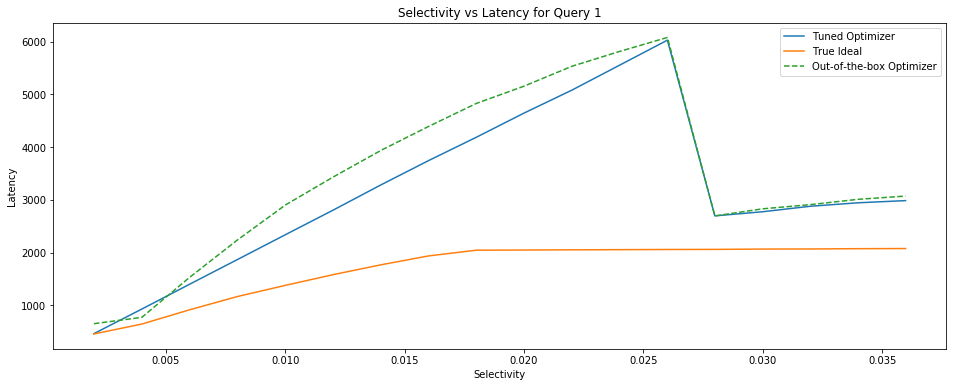

In [21]:
plt.figure(figsize=(16, 6))

plt.plot(df_t2_tuned["selectivity"], df_t2_tuned["latency"], label="Tuned Optimizer")

plt.plot(df_t2_grid["selectivity"], df_t2_grid["latency"], label="True Ideal")

q_o = df_t2_control.sort_values("selectivity", ascending=True)
plt.plot(q_o["selectivity"], q_o["latency"], label="Out-of-the-box Optimizer",linestyle='dashed')

plt.title("Selectivity vs Latency for Query 1")
plt.ylabel("Latency")
plt.xlabel("Selectivity")
plt.legend()

let's turn the fastest queries into a script we can run and get a bunch of times... that way we can use a balanced set for machine learning


### Query 2

All agree it should be scan

In [99]:
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

In [100]:
find_best(df_c5_t3[df_c5_t3["query"] == 2])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
203,2,1529576.06,467391,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0,2,3-2,0.020002,2921.630
204,2,1530857.01,979772,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0,2,3-2,0.039981,2933.742
205,2,1532029.66,1448830,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0,2,3-2,0.060007,2981.543


In [101]:
find_best(df_r5_t3[df_r5_t3["query"] == 2])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
203,2,1529646.88,495718,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0,2,3-2,0.020002,3150.248
204,2,1530823.69,966442,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0,2,3-2,0.039981,3157.467
205,2,1532098.39,1476323,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0,2,3-2,0.060007,3202.633


In [102]:
find_best(df_m5_t3[df_m5_t3["query"] == 2])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
203,2,1529678.12,508215,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0,2,3-2,0.020002,3170.159
204,2,1530971.57,1025595,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0,2,3-2,0.039981,3183.563
205,2,1532252.52,1537976,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0,2,3-2,0.060007,3199.854


In [70]:
df_c5_t4 = pd.read_csv('tests/final/c5d4xlarge-test4.txt')
df_r5_t4 = pd.read_csv('tests/final/r5d4xlarge-test4.txt')
df_m5_t4 = pd.read_csv('tests/final/m5d2xlarge-test4-2.txt')

In [66]:
df_c5_t4.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'query', 'batch',
       'selectivity', 'latency', 'forced_parallel'],
      dtype='object')

In [69]:
df_m5_t4[['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'selectivity', 'latency']].to_csv("tests/final/m5d2xlarge-test4-2.txt", index=False)

In [67]:
df_c5_t3.columns

Index(['workers', 'cost', 'rows', 'type', 'parallel', 'i_q', 'i_p', 'i_s',
       'i_e', 'i_d', 'i_o_q', 'i_o_p', 'i_o_s', 'i_o_e', 'i_o_d', 'b_i_q',
       'b_i_p', 'b_i_s', 'b_i_e', 'b_i_d', 's_q', 's_p', 's_s', 's_e', 's_d',
       'o_q', 'o_p', 'o_s', 'o_e', 'o_d', 'v_i_q', 'v_i_p', 'v_i_s', 'v_i_e',
       'v_i_d', 'v_f_q', 'v_f_p', 'v_f_s', 'v_f_e', 'v_f_d', 'forced_parallel',
       'query', 'batch', 'selectivity', 'latency'],
      dtype='object')

In [75]:
#let's combine tests 3 & 4
df_c5 = pd.concat([df_c5_t3,df_c5_t4])
df_r5 = pd.concat([df_r5_t3,df_r5_t4])
df_m5 = pd.concat([df_m5_t3,df_m5_t4])

In [103]:
#the best of the combined tests
find_best(df_c5[df_c5["query"]==2])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
203,2,1529576.06,467391,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0,2,3-2,0.020002,2921.630
204,2,1530857.01,979772,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0,2,3-2,0.039981,2933.742
205,2,1532029.66,1448830,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0,2,3-2,0.060007,2981.543


In [121]:
df_c5[df_c5["query"]==2]["latency"].describe()

count       21.000000
mean      5946.209905
std       2552.914984
min       2921.630000
25%       3060.797000
50%       7138.776000
75%       7838.633000
max      10936.224000
Name: latency, dtype: float64

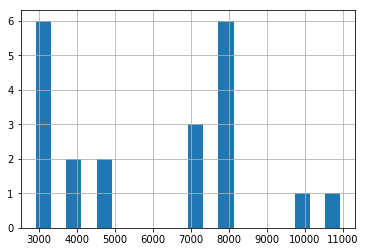

In [118]:
df_c5[df_c5["query"]==2]["latency"].hist(bins=20)

We see clear clusters, which we'd expect in this query. The fastest use scan with multiple workers, then the 7000-8000 ms scan with 1 worker, and the 10000-11000 are index probes

In [120]:
df_c5[(df_c5["query"]==2) & (df_c5["latency"] < 3500)]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
203,2,1529576.06,467391,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0,2,3-2,0.020002,2921.630
204,2,1530857.01,979772,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0,2,3-2,0.039981,2933.742
205,2,1532029.66,1448830,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0,2,3-2,0.060007,2981.543
203,2,1529767.38,534085,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,2,0,0,0,0.0,0,2,42,0.020002,3013.602
204,2,1531071.34,1055671,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,3,0,0,0,0.0,0,2,42,0.039981,3013.568
205,2,1532333.65,1560593,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,4,0,0,0,0.0,0,2,42,0.060007,3060.797


In [157]:
find_best(df_c5_t2)

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,parllelmode,parallelsetupcost,seq_page_cost,random_page_cost,cpu_tuple_cost,cpu_index_tuple_cost,cpu_operator_cost,parallel_tuple_cost,min_parallel_relation_size,effective_cache_size,selectivity,latency
1044,0,465155.12,115397,index,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4000,0,0,0,0,0,0,0,0,0,1,2-60,0,1000,1,1,0.05,0.005,0.0025,0.2,8.0,4,0.001997,455.321
1513,2,590395.17,96176,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8000,0,0,0,0,0,0,0,0,0,1,2-86,0,1000,1,1,0.05,0.005,0.0025,0.1,8.0,4,0.004005,643.618
1514,2,779102.87,145937,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,12000,0,0,0,0,0,0,0,0,0,1,2-86,0,1000,1,1,0.05,0.005,0.0025,0.1,8.0,4,0.006006,913.889
1497,2,916710.31,194031,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,16000,0,0,0,0,0,0,0,0,0,1,2-85,0,1000,1,1,0.04,0.005,0.0025,0.1,8.0,4,0.008006,1165.414
1516,2,1030261.90,243792,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,20000,0,0,0,0,0,0,0,0,0,1,2-86,0,1000,1,1,0.05,0.005,0.0025,0.1,8.0,4,0.010013,1377.310
1499,2,1116919.72,295828,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,24000,0,0,0,0,0,0,0,0,0,1,2-85,0,1000,1,1,0.04,0.005,0.0025,0.1,8.0,4,0.012015,1580.326
1518,2,1190905.72,350293,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,28000,0,0,0,0,0,0,0,0,0,1,2-86,0,1000,1,1,0.05,0.005,0.0025,0.1,8.0,4,0.014010,1766.848
1501,2,1238479.68,403092,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,32000,0,0,0,0,0,0,0,0,0,1,2-85,0,1000,1,1,0.04,0.005,0.0025,0.1,8.0,4,0.016010,1935.433
458,2,1529551.85,455892,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,36000,0,0,0,0,1,2-27,0,1000,1,1,0.05,0.005,0.0025,0.2,8.0,4,0.018008,2043.926
441,2,1529683.13,508165,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,40000,0,0,0,0,1,2-26,0,1000,1,1,0.05,0.005,0.0025,0.5,8.0,4,0.019997,2046.826


### Query 3

All agree it should be scan except for the first 3 should use index scan on i_sk. We should see those same familiar clusters.

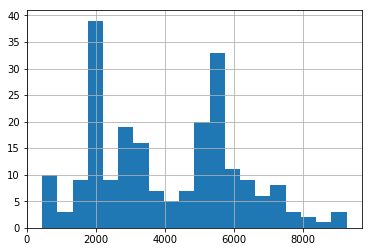

In [122]:
df_c5[df_c5["query"]==3]["latency"].hist(bins=20)

In [126]:
df_c5[df_c5["query"]==3]["latency"].describe()

count     220.000000
mean     4041.829168
std      2014.310064
min       446.121000
25%      2192.757500
50%      3936.623000
75%      5388.422000
max      9248.617000
Name: latency, dtype: float64

This time, take a look at the first 4 rows below. It shows us that at first, index probes are faster (because there are less matches to probe), then at some tipping point, the cost of probe is so high, we might as well scan.

We won't make these observations on every query, but the same pattern will apply. The other queries are included for our reference.

In [104]:
find_best(df_c5[df_c5["query"]==3])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
622,0,439928.47,114225,index,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,200,0,0.0,0,0,0,0,0.0,0,3,3-5,0.001988,446.121
623,0,823915.34,222995,index,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,400,0,0.0,0,0,0,0,0.0,0,3,3-5,0.003990,883.995
624,0,1202862.19,339764,index,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,600,0,0.0,0,0,0,0,0.0,0,3,3-5,0.005992,1338.053
625,0,1562889.03,460531,index,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,800,0,0.0,0,0,0,0,0.0,0,3,3-5,0.007983,1784.026
210,2,1529000.56,237190,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0,0,1000,0,0.0,0,3,3-2,0.009987,2072.646
211,2,1529124.58,286798,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0,0,1200,0,0.0,0,3,3-2,0.011992,2082.745
212,2,1529257.64,340022,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0,0,1400,0,0.0,0,3,3-2,0.013989,2075.044
213,2,1529390.70,393246,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0,0,1600,0,0.0,0,3,3-2,0.015992,2097.405
214,2,1529523.76,446470,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0,0,1800,0,0.0,0,3,3-2,0.018001,2088.085
215,2,1529663.07,502193,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.0,0,0,2000,0,0.0,0,3,3-2,0.019995,2105.709


## Query 4
r5 and c5 agree. m5 doesn't.

This shows us the "tipping point", a.k.a. "access path" is also somewhat dependent on hardware.

In [169]:
find_best(df_c5[df_c5["query"]==4])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
907,0,3249475.87,104546,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.01,0,4,3-6c,0.001821,2542.546
908,0,3249733.59,207634,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.02,0,4,3-6c,0.003633,2547.232
909,0,3249983.93,307768,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.03,0,4,3-6c,0.005452,2552.088
910,0,3250239.50,409996,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.04,0,4,3-6c,0.007274,2560.343
911,0,3250495.35,512336,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.05,0,4,3-6c,0.009103,2565.423
912,0,3250741.94,610974,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.06,0,4,3-6c,0.010922,2572.127
913,0,3250996.86,712940,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.07,0,4,3-6c,0.012741,2575.603
914,0,3251249.06,813822,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.08,0,4,3-6c,0.014559,2579.619
915,0,3251506.97,916984,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.09,0,4,3-6c,0.016365,2582.662
916,0,3251762.73,1019287,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.10,0,4,3-6c,0.018190,2584.209


In [131]:
find_best(df_m5[df_m5["query"]==4])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
963,0,3494035.73,106563,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.01,0,4,3-8,0.001821,2652.193
964,0,3494316.47,218858,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.02,0,4,3-8,0.003633,2665.178
227,2,1591136.37,91195,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,2,0,0,0,0.02,0,4,42,0.003633,3483.168
965,0,3494590.90,328632,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.03,0,4,3-8,0.005452,2666.712
966,0,3494868.29,439586,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.04,0,4,3-8,0.007274,2679.997
967,0,3495153.39,553629,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.05,0,4,3-8,0.009103,2684.456
968,0,3495434.13,665924,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.06,0,4,3-8,0.010922,2698.494
969,0,3495709.69,776146,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.07,0,4,3-8,0.012741,2704.106
232,2,1591716.90,323408,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,2,0,0,0,0.07,0,4,42,0.012741,3832.528
970,0,3495981.68,884945,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.08,0,4,3-8,0.014559,2716.773


## Query 5
All agree

In [105]:
find_best(df_c5[df_c5["query"]==5])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
922,0,3249475.87,104546,index,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,2,0,0,0,0.0,0,0,0,0,0.01,0,5,3-6c,0.001821,2536.668
242,2,1591121.34,91315,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,3,0,0,0,0.01,0,5,3-2,0.003634,3151.768
243,2,1591230.63,135031,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,4,0,0,0,0.01,0,5,3-2,0.005449,3145.954
244,2,1591347.10,181620,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,5,0,0,0,0.01,0,5,3-2,0.007263,3156.822
245,2,1591474.06,232402,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,6,0,0,0,0.01,0,5,3-2,0.009086,3155.609
246,2,1591592.08,279612,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,7,0,0,0,0.01,0,5,3-2,0.010896,3162.348
247,2,1591717.10,329618,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,8,0,0,0,0.01,0,5,3-2,0.012707,3162.157
248,2,1591833.38,376130,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,9,0,0,0,0.01,0,5,3-2,0.014525,3163.131
249,2,1591946.94,421554,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,10,0,0,0,0.01,0,5,3-2,0.016338,3165.517
250,2,1592063.22,468066,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,0,0,0,1,0,0,0,0,0.0,11,0,0,0,0.01,0,5,3-2,0.018166,3164.187


## Query 6
All unique

In [110]:
find_best(df_c5[df_c5["query"]==6])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
254,0,813532.50,219697,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,100000,0.0,0,0,0,0,0.0,0,6,42,0.000684,163.531
255,0,961939.89,264085,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,99000,0.0,0,0,0,0,0.0,0,6,42,0.001100,260.553
1021,0,1105387.55,308431,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,98000,0.0,0,0,0,0,0.0,0,6,3-10,0.001650,387.729
257,0,1244690.69,352860,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,97000,0.0,0,0,0,0,0.0,0,6,42,0.002373,566.703
258,0,1379486.12,397248,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,96000,0.0,0,0,0,0,0.0,0,6,42,0.003261,781.264
259,2,1529276.93,337904,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.0,0,0,0,90000,0.0,0,6,42,0.004384,1052.363
463,0,1636897.00,486024,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,94000,0.0,0,0,0,0,0.0,0,6,43,0.005693,1387.197
464,0,1759880.44,530411,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,93000,0.0,0,0,0,0,0.0,0,6,43,0.007239,1777.727
1027,0,1875651.79,574722,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,92000,0.0,0,0,0,0,0.0,0,6,3-10,0.008979,2164.921
1028,0,2122859.11,670818,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,91000,0.0,0,0,0,0,0.0,0,6,3-10,0.010934,2709.330


In [137]:
find_best(df_r5[df_r5["query"]==6])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
254,0,838702.90,227122,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,100000,0.0,0,0,0,0,0.0,0,6,42,0.000684,162.727
1020,0,975612.64,268248,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,99000,0.0,0,0,0,0,0.0,0,6,3-10,0.001100,257.813
1021,0,1121046.26,313336,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,98000,0.0,0,0,0,0,0.0,0,6,3-10,0.001650,387.031
1022,0,1261819.87,358423,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,97000,0.0,0,0,0,0,0.0,0,6,3-10,0.002373,558.436
1023,0,1398169.51,403511,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,96000,0.0,0,0,0,0,0.0,0,6,3-10,0.003261,769.580
1024,0,1530295.15,448599,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,95000,0.0,0,0,0,0,0.0,0,6,3-10,0.004384,1036.053
1025,0,1658392.77,493686,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,94000,0.0,0,0,0,0,0.0,0,6,3-10,0.005693,1349.908
1026,0,1782646.41,538774,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,93000,0.0,0,0,0,0,0.0,0,6,3-10,0.007239,1722.476
465,0,1925936.81,594225,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,92000,0.0,0,0,0,0,0.0,0,6,43,0.008979,2142.780
1180,1,2202706.69,701807,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,91000,0.0,0,0,0,0,0.0,1,6,3-10a,0.010934,2601.835


In [136]:
find_best(df_m5[df_m5["query"]==6])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
1019,0,827136.71,223716,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,100000,0.0,0,0,0,0,0.0,0,6,3-10,0.000684,164.714
1020,0,977753.74,268915,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,99000,0.0,0,0,0,0,0.0,0,6,3-10,0.001100,262.148
1021,0,1123467.03,314115,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,98000,0.0,0,0,0,0,0.0,0,6,3-10,0.001650,394.730
1022,0,1264500.54,359315,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,97000,0.0,0,0,0,0,0.0,0,6,3-10,0.002373,567.664
1023,0,1401090.23,404514,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,96000,0.0,0,0,0,0,0.0,0,6,3-10,0.003261,786.369
1024,0,1533440.14,449714,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,95000,0.0,0,0,0,0,0.0,0,6,3-10,0.004384,1052.759
1025,0,1661750.25,494914,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,94000,0.0,0,0,0,0,0.0,0,6,3-10,0.005693,1378.669
1026,0,1786200.51,540113,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,93000,0.0,0,0,0,0,0.0,0,6,3-10,0.007239,1746.358
1027,0,1902923.15,585313,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,92000,0.0,0,0,0,0,0.0,0,6,3-10,0.008979,2168.002
1028,0,2207867.95,703852,index,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,91000,0.0,0,0,0,0,0.0,0,6,3-10,0.010934,2642.936


## Query 7
All Agree

In [161]:
find_best(df_c5[df_c5["query"]==7])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
3251,2,1288011.07,57199,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,80000,0.0,0,7,3-20,0.001862,3322.730
276,2,1591181.42,115345,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,200000,0,80000,0.0,0,7,3-2,0.004769,3401.711
277,2,1591323.47,172165,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,300000,0,80000,0.0,0,7,3-2,0.006620,3404.820
278,2,1591472.03,231589,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,400000,0,80000,0.0,0,7,3-2,0.009530,3409.288
279,2,1591619.06,290402,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,500000,0,80000,0.0,0,7,3-2,0.011396,3410.244
280,2,1591762.01,347582,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,600000,0,80000,0.0,0,7,3-2,0.014299,3415.457
281,2,1591915.10,408820,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,700000,0,80000,0.0,0,7,3-2,0.016157,3414.521
282,2,1592066.51,469381,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,800000,0,80000,0.0,0,7,3-2,0.019068,3416.543
283,2,1592214.89,528733,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,900000,0,80000,0.0,0,7,3-2,0.020926,3419.629
284,2,1592365.74,589073,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,0,0,0,0,0,0.0,0,1000000,0,80000,0.0,0,7,3-2,0.023831,3425.451


## Query 8
All agree

In [159]:
find_best(df_c5[df_c5["query"]==8])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
3500,2,1293414.78,61490,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,2,0,0,0,5000,0,0.0,0,0,0,80000,0.0,0,8,3-22,0.002269,3373.402
296,2,1591192.28,119690,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,10000,80000,0.0,0,8,3-2,0.004595,3398.731
297,2,1591336.61,177421,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,15000,80000,0.0,0,8,3-2,0.006979,3406.501
298,2,1591485.88,237131,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,20000,80000,0.0,0,8,3-2,0.009409,3404.504
299,2,1591637.88,297932,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,25000,80000,0.0,0,8,3-2,0.011892,3410.208
300,2,1591782.22,355665,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,30000,80000,0.0,0,8,3-2,0.014171,3410.120
301,2,1591931.40,415337,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,35000,80000,0.0,0,8,3-2,0.016504,3420.046
302,2,1592075.70,473060,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,40000,80000,0.0,0,8,3-2,0.018886,3418.357
303,2,1592221.39,531334,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,45000,80000,0.0,0,8,3-2,0.021316,3426.824
304,2,1592367.11,589623,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,80000,0.0,0,8,3-2,0.023799,3425.717


## Query 9
All agree but m5

In [160]:
find_best(df_c5[df_c5["query"]==9])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
1660,0,8.61,1,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,0,1,0,0,0,0,120000,0.0,0,100000,0,0,0.0,0,9,3-29,0.000000,0.128
1079,0,1509952.00,21398,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,95000,0.0,0,100000,0,0,0.0,0,9,3-10,0.000071,1040.173
1454,1,2489856.46,39418,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,90000,0.0,0,100000,0,0,0.0,1,9,3-12,0.000385,3155.822
3273,2,1287936.30,33080,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,85000,0.0,0,9,3-20,0.000980,3332.387
3272,2,1288011.07,57199,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,80000,0.0,0,9,3-20,0.001862,3338.243
3271,2,1288113.24,90158,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,75000,0.0,0,9,3-20,0.003061,3326.389
314,0,1510207.37,21526,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,95000,0.0,0,100000,0,0,0.0,0,9,42,713165.787273,1040.690


In [140]:
find_best(df_m5[df_m5["query"]==9])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
1084,0,8.60,1,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,120000,0.0,0,100000,0,0,0.0,0,9,3-10,0.000000,0.137
1347,0,1533498.53,23356,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,95000,0.0,0,100000,0,0,0.0,0,9,3-11,0.000071,1079.167
1346,0,2569507.70,43853,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,90000,0.0,0,100000,0,0,0.0,0,9,3-11,0.000385,3211.395
3273,2,1289399.18,34541,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,85000,0.0,0,9,3-20,0.000980,3587.900
3272,2,1289475.44,59139,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,80000,0.0,0,9,3-20,0.001862,3554.356
3271,2,1289575.11,91291,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,2,0,0,100000,0,0,0.0,0,0,0,75000,0.0,0,9,3-20,0.003061,3566.229
517,0,1533550.89,23357,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,0,0,0,0,95000,0.0,0,100000,0,0,0.0,0,9,43,713165.787273,1075.344


## Query 10
All agree

In [162]:
find_best(df_c5[df_c5["query"]==10])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2752,0,1510449.95,220578,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,0,0,0,0,95000,0.0,0,0,50000,0,0.0,0,10,3-15,0.002184,1012.045
2751,0,1876369.50,287087,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,0,0,0,0,92000,0.0,0,0,50000,0,0.0,0,10,3-15,0.004485,2073.998
325,2,1591464.74,228675,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,88000,0.0,0,10,3-2,0.009074,3401.220
324,2,1591745.54,340996,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,85000,0.0,0,10,3-2,0.013707,3415.244
323,2,1592102.94,483953,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,82000,0.0,0,10,3-2,0.019416,3416.579
322,2,1592367.11,589623,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,80000,0.0,0,10,3-2,0.023799,3427.171
321,2,1592853.54,784194,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,77000,0.0,0,10,3-2,0.031365,3455.023
320,2,1593216.47,929366,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,0,0,0,0,0,0.0,0,0,50000,75000,0.0,0,10,3-2,0.037031,3480.667


## Query 11
All agree

In [86]:
find_best(df_c5[df_c5["query"]==11])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
340,2,1653550.26,68695,scan,1,0,0,0,0,0,...,0,1200000,6000,75000,0.0,0,11,3-2,0.002565,3422.664
339,2,1653716.30,135110,scan,1,0,0,0,0,0,...,0,1200000,12000,75000,0.0,0,11,3-2,0.005199,3429.170
338,2,1653880.84,200924,scan,1,0,0,0,0,0,...,0,1200000,18000,75000,0.0,0,11,3-2,0.007897,3436.029
337,2,1654051.28,269102,scan,1,0,0,0,0,0,...,0,1200000,24000,75000,0.0,0,11,3-2,0.010646,3426.549
336,2,1654217.83,335721,scan,1,0,0,0,0,0,...,0,1200000,30000,75000,0.0,0,11,3-2,0.013256,3450.214
335,2,1654385.94,402966,scan,1,0,0,0,0,0,...,0,1200000,36000,75000,0.0,0,11,3-2,0.015886,3440.818
334,2,1654546.88,467341,scan,1,0,0,0,0,0,...,0,1200000,42000,75000,0.0,0,11,3-2,0.018567,3452.544
333,2,1654716.50,535191,scan,1,0,0,0,0,0,...,0,1200000,48000,75000,0.0,0,11,3-2,0.021309,3456.123
332,2,1654883.69,602066,scan,1,0,0,0,0,0,...,0,1200000,54000,75000,0.0,0,11,3-2,0.023942,3462.339
331,2,1655045.95,666969,scan,1,0,0,0,0,0,...,0,1200000,60000,75000,0.0,0,11,3-2,0.026555,3460.573


## Query 12
All agree

In [147]:
find_best(df_c5[df_c5["query"]==12])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
3294,2,1291071.04,67528,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,3,2,0,0,100000,0,0,0.0,0,0,75000,75000,0.0,0,12,3-20,0.002298,3341.834
342,2,1653718.96,136175,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,200000,75000,75000,0.0,0,12,3-2,0.005565,3424.550
343,2,1653886.66,203255,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,300000,75000,75000,0.0,0,12,3-2,0.007845,3444.107
344,2,1654062.05,273410,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,400000,75000,75000,0.0,0,12,3-2,0.011107,3431.675
345,2,1654235.64,342844,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,500000,75000,75000,0.0,0,12,3-2,0.013403,3446.748
346,2,1654404.40,410349,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,600000,75000,75000,0.0,0,12,3-2,0.016662,3442.909
347,2,1654585.14,482645,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,700000,75000,75000,0.0,0,12,3-2,0.018957,3445.294
348,2,1654763.88,554143,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,800000,75000,75000,0.0,0,12,3-2,0.022227,3462.376
349,2,1654939.06,624213,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,900000,75000,75000,0.0,0,12,3-2,0.024511,3458.740
350,2,1655117.15,695450,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1000000,75000,75000,0.0,0,12,3-2,0.027783,3458.536


## Query 13
None agree

In [163]:
find_best(df_c5[df_c5["query"]==13])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
3018,0,1511497.62,198068,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,1200000,75000,0,0.0,0,13,3-17,0.001973,1013.671
2783,0,1761507.56,237883,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.003265,1671.502
2782,0,2492703.68,364867,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.005914,3026.513
356,2,1653966.28,235101,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,87000,0.0,0,13,3-2,0.009475,3407.367
355,2,1654238.21,343875,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,84000,0.0,0,13,3-2,0.013953,3416.367
354,2,1654582.84,481726,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,81000,0.0,0,13,3-2,0.019415,3420.009
353,2,1654983.75,642090,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,78000,0.0,0,13,3-2,0.025862,3447.649
352,2,1655464.84,834526,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,75000,0.0,0,13,3-2,0.033338,3473.531


In [149]:
find_best(df_m5[df_m5["query"]==13])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2784,0,1501925.98,198312,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.001973,1055.563
3017,0,1750704.18,238179,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1200000,75000,0,0.0,0,13,3-17,0.003265,1743.757
2782,0,2460795.52,362456,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.005914,3158.516
357,2,1653795.60,159680,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,90000,0.0,0,13,42,0.005914,3724.767
1849,2,1311009.45,249458,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,87000,0.0,0,1200000,75000,0,0.0,0,13,3-30,0.009475,3456.579
355,2,1654300.04,368606,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,84000,0.0,0,13,3-2,0.013953,3696.862
354,2,1654653.49,509986,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,81000,0.0,0,13,3-2,0.019415,3708.371
353,2,1655055.63,670841,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,78000,0.0,0,13,3-2,0.025862,3739.051
352,2,1655553.48,869983,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,75000,0.0,0,13,3-2,0.033338,3765.259


In [150]:
find_best(df_r5[df_r5["query"]==13])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2784,0,1528903.59,200734,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.001973,1025.587
2783,0,1781182.17,241084,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.003265,1693.482
2782,0,2583960.42,380700,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1200000,75000,0,0.0,0,13,3-15,0.005914,3064.513
1849,2,1310106.65,248400,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,87000,0.0,0,1200000,75000,0,0.0,0,13,3-30,0.009475,3468.629
355,2,1654292.35,359685,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,84000,0.0,0,13,42,0.013953,3719.465
354,2,1654640.26,498849,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,81000,0.0,0,13,42,0.019415,3719.343
353,2,1655067.39,669700,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,78000,0.0,0,13,42,0.025862,3759.827
352,2,1655530.07,854772,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,75000,75000,0.0,0,13,42,0.033338,3775.061


## Query 14
None agree

In [164]:
find_best(df_c5[df_c5["query"]==14])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2800,0,1511829.22,330710,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,2000000,75000,0,0.0,0,14,3-15,0.003287,1017.223
3033,0,1638719.91,352943,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,94000,0.0,0,1940000,75000,0,0.0,0,14,3-17,0.004025,1321.599
2798,0,1761846.03,373272,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1880000,75000,0,0.0,0,14,3-15,0.004969,1679.928
3031,0,1878066.21,391049,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,92000,0.0,0,1820000,75000,0,0.0,0,14,3-17,0.006085,2082.558
3030,0,2125639.94,441514,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,91000,0.0,0,1760000,75000,0,0.0,0,14,3-17,0.007100,2535.644
2694,1,2493083.82,516922,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1700000,75000,0,0.0,1,14,3-14,0.008168,3037.266
369,2,1653988.54,244005,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1640000,75000,89000,0.0,0,14,3-2,0.009445,3399.522
368,2,1654055.05,270609,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1580000,75000,88000,0.0,0,14,3-2,0.010669,3399.082
367,2,1654124.60,298430,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1520000,75000,87000,0.0,0,14,3-2,0.011741,3407.308
366,2,1654203.43,329962,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1460000,75000,86000,0.0,0,14,3-2,0.012986,3404.601


In [151]:
find_best(df_m5[df_m5["query"]==14])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
3034,0,1502274.61,329703,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,2000000,75000,0,0.0,0,14,3-17,0.003287,1068.221
2799,0,1628495.45,352035,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,94000,0.0,0,1940000,75000,0,0.0,0,14,3-15,0.004025,1380.458
2798,0,1751019.29,372296,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1880000,75000,0,0.0,0,14,3-15,0.004969,1750.964
3031,0,1867053.19,390055,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,92000,0.0,0,1820000,75000,0,0.0,0,14,3-17,0.006085,2171.970
2796,0,2089608.20,434380,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,91000,0.0,0,1760000,75000,0,0.0,0,14,3-15,0.007100,2633.441
3029,0,2461193.41,510305,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1700000,75000,0,0.0,0,14,3-17,0.008168,3172.981
369,2,1654013.48,253982,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1640000,75000,89000,0.0,0,14,3-2,0.009445,3695.313
368,2,1654078.03,279803,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1580000,75000,88000,0.0,0,14,3-2,0.010669,3700.131
1860,2,1311221.56,317881,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,87000,0.0,0,1520000,75000,0,0.0,0,14,3-30,0.011741,3497.679
975,2,1325683.05,347367,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,86000,0.0,0,1460000,75000,0,0.0,0,14,45,0.012986,3697.178


In [152]:
find_best(df_r5[df_r5["query"]==14])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2800,0,1529236.14,333753,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,2000000,75000,0,0.0,0,14,3-15,0.003287,1029.493
2799,0,1657298.61,356052,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,94000,0.0,0,1940000,75000,0,0.0,0,14,3-15,0.004025,1335.574
2798,0,1781519.71,376100,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1880000,75000,0,0.0,0,14,3-15,0.004969,1697.921
2797,0,1898213.41,394545,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,92000,0.0,0,1820000,75000,0,0.0,0,14,3-15,0.006085,2104.331
2796,0,2202339.80,458872,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,91000,0.0,0,1760000,75000,0,0.0,0,14,3-15,0.007100,2562.348
2795,0,2584351.49,537126,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1700000,75000,0,0.0,0,14,3-15,0.008168,3083.095
2794,0,2966347.83,609231,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,89000,0.0,0,1640000,75000,0,0.0,0,14,3-15,0.009445,3642.388
368,2,1654126.00,293146,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1580000,75000,88000,0.0,0,14,42,0.010669,3709.760
2076,2,1310309.21,313742,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,87000,0.0,0,1520000,75000,0,0.0,0,14,3-32,0.011741,3470.274
1859,2,1326850.92,348327,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,86000,0.0,0,1460000,75000,0,0.0,0,14,3-30,0.012986,3648.906


## Query 15
All agree but m5

In [165]:
find_best(df_c5[df_c5["query"]==15])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2816,0,1511497.62,198068,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,1200000,75000,0,0.0,0,15,3-15,0.001973,1012.403
3049,0,1638338.00,200180,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,94000,0.0,0,1200000,69000,0,0.0,0,15,3-17,0.002335,1315.590
2814,0,1761451.62,215508,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1200000,68000,0,0.0,0,15,3-15,0.002929,1671.877
2813,0,1877664.05,230184,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,92000,0.0,0,1200000,67000,0,0.0,0,15,3-15,0.003581,2072.052
2812,0,2125197.59,264572,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,91000,0.0,0,1200000,66000,0,0.0,0,15,3-15,0.004295,2523.276
3123,1,2492581.34,315929,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1200000,65000,0,0.0,1,15,3-18,0.005075,3026.173
385,2,1653759.26,152294,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,64000,89000,0.0,0,15,3-2,0.005925,3388.532
384,2,1653809.05,172211,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,63000,88000,0.0,0,15,3-2,0.006807,3396.077
383,2,1653864.27,194299,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,62000,87000,0.0,0,15,3-2,0.007768,3400.926
382,2,1653929.00,220188,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,61000,86000,0.0,0,15,3-2,0.008764,3396.649


In [153]:
find_best(df_m5[df_m5["query"]==15])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,i_o_q,i_o_p,i_o_s,i_o_e,i_o_d,b_i_q,b_i_p,b_i_s,b_i_e,b_i_d,s_q,s_p,s_s,s_e,s_d,o_q,o_p,o_s,o_e,o_d,v_i_q,v_i_p,v_i_s,v_i_e,v_i_d,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
2816,0,1501925.98,198312,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,95000,0.0,0,1200000,75000,0,0.0,0,15,3-15,0.001973,1055.051
2815,0,1628115.73,200150,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,94000,0.0,0,1200000,69000,0,0.0,0,15,3-15,0.002335,1363.394
2814,0,1750626.83,215311,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,93000,0.0,0,1200000,68000,0,0.0,0,15,3-15,0.002929,1737.084
2813,0,1866632.70,229933,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,92000,0.0,0,1200000,67000,0,0.0,0,15,3-15,0.003581,2161.766
2812,0,2089174.49,260898,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,91000,0.0,0,1200000,66000,0,0.0,0,15,3-15,0.004295,2619.132
590,0,2210410.65,282571,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,91000,0.0,0,1200000,66000,0,0.0,0,15,43,0.004295,2738.643
2811,0,2460672.67,313315,index,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,1,3,0,0,0,0,90000,0.0,0,1200000,65000,0,0.0,0,15,3-15,0.005075,3135.752
385,2,1653778.47,159978,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,64000,89000,0.0,0,15,3-2,0.005925,3672.984
384,2,1653828.68,180061,scan,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,3,2,1,0,0,0,0,0,0.0,0,1200000,63000,88000,0.0,0,15,3-2,0.006807,3656.161
1876,2,1310871.90,205086,bitmap,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,3,2,1,0,0,0,0,87000,0.0,0,1200000,62000,0,0.0,0,15,3-30,0.007768,3480.039


## Query 16
All agree

In [92]:
find_best(df_c5[df_c5["query"]==16])

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
392,2,1653521.96,57375,scan,1,0,0,0,0,0,...,0,250000,25000,75000,0.0,0,16,3-2,0.002187,3421.811
393,2,1653582.94,81767,scan,1,0,0,0,0,0,...,0,300000,30000,75000,0.0,0,16,3-2,0.003112,3419.051
394,2,1653658.06,111813,scan,1,0,0,0,0,0,...,0,350000,35000,75000,0.0,0,16,3-2,0.004320,3426.369
395,2,1653744.26,146295,scan,1,0,0,0,0,0,...,0,400000,40000,75000,0.0,0,16,3-2,0.005867,3421.535
396,2,1653842.47,185577,scan,1,0,0,0,0,0,...,0,450000,45000,75000,0.0,0,16,3-2,0.007238,3433.700
397,2,1653950.15,228648,scan,1,0,0,0,0,0,...,0,500000,50000,75000,0.0,0,16,3-2,0.008920,3423.742
398,2,1654069.28,276301,scan,1,0,0,0,0,0,...,0,550000,55000,75000,0.0,0,16,3-2,0.010872,3442.051
399,2,1654198.42,327958,scan,1,0,0,0,0,0,...,0,600000,60000,75000,0.0,0,16,3-2,0.013262,3437.494
400,2,1654347.19,387466,scan,1,0,0,0,0,0,...,0,650000,65000,75000,0.0,0,16,3-2,0.015275,3445.272
401,2,1654502.11,449433,scan,1,0,0,0,0,0,...,0,700000,70000,75000,0.0,0,16,3-2,0.017649,3442.915
